In [1]:
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogLocator, FuncFormatter
from matplotlib.patches import Patch
import seaborn as sns

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

from pathlib import Path
from glob import glob
import solar_plotting

from spectrum import pmtm
import pywt
from scipy.signal import welch

In [2]:
plt.rcParams.update({
    'axes.titlesize': 22,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

In [3]:
fig_dir = '/home/548/cd3022/aus-historical-solar-droughts/figs/REZ/CF/'

# Prepare Data

In [4]:
# regions = ['Q', 'N', 'V', 'S', 'T']  # States
regions = ['Q2', 'Q8', 'N3', 'N5', 'V5', 'V6', 'T1', 'T3', 'S7', 'S8'] # REZs
ncols = (len(regions) + 1) // 2 # plotting
base_path = Path('/g/data/er8/users/cd3022/solar_drought/REZ/capacity_factor/')

region_darrays = {}

for region in regions:
    file_path = base_path / region
    files = list(file_path.rglob("*.nc"))
    ds_region = xr.open_mfdataset(files, combine='by_coords')
    
    # Assume there's only one data variable in the dataset
    data_var = list(ds_region.data_vars)[0]
    region_darrays[region] = ds_region[data_var]

# Combine into one dataset, with each region as a variable
ds_aus = xr.Dataset(region_darrays)
ds_aus = ds_aus.load()

time_utc = pd.to_datetime(ds_aus.time.values)
time_aest = time_utc.tz_localize("UTC").tz_convert("Australia/Brisbane")
time_aest_naive = time_aest.tz_convert("Australia/Brisbane").tz_localize(None)
ds_aus = ds_aus.assign_coords(time=("time", time_aest_naive))

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [11]:
# Rated capacity taken from sandia_modules['Canadian_Solar_CS5P_220M___2009_'], solar panel used in pvlib system,
# using the calculation rated_capacity = module.loc['Impo'] * module.loc['Vmpo']
rated_capacity = 219.656729124
ds_raw = ds_aus.apply(lambda x: x / rated_capacity) # raw data can be used for load duration curves, before morning/evening data is removed in "clip_dusk_dawn"

# Remove missing moddle of the day time

In [12]:
ds_aus = ds_raw.where(ds_aus['time'].dt.strftime('%H:%M') != '12:40', drop=True)

# Investigate bad data

In [13]:
# Group by day
grouped = ds_aus.groupby('time.date')

# Function to get difference between 32nd and 33rd index (i.e., index 31 and 32)
def get_daily_diff(group):
    try:
        return group.isel(time=33) - group.isel(time=32)
    except IndexError:
        # If a day has fewer than 33 time steps (e.g., incomplete day), skip
        return xr.full_like(group.isel(time=0), fill_value=np.nan)

# Apply to all variables
diffs = {}
for var in ds_aus.data_vars:
    diffs[var] = grouped.map(lambda g: get_daily_diff(g[var]))

# Combine into a Dataset
diff_ds = xr.Dataset(diffs)

# Convert to DataFrame for easier plotting
diff_df = diff_ds.to_dataframe()

In [ ]:
reg = 'Q2'
for date in diff_df[diff_df[reg] > 0.05].index:
    data = ds_aus[reg].sel(time=f'{date}')
    data.plot()
    bad_time = data.time.values[32]
    print(bad_time)
    plt.axvline(bad_time)
    plt.show()

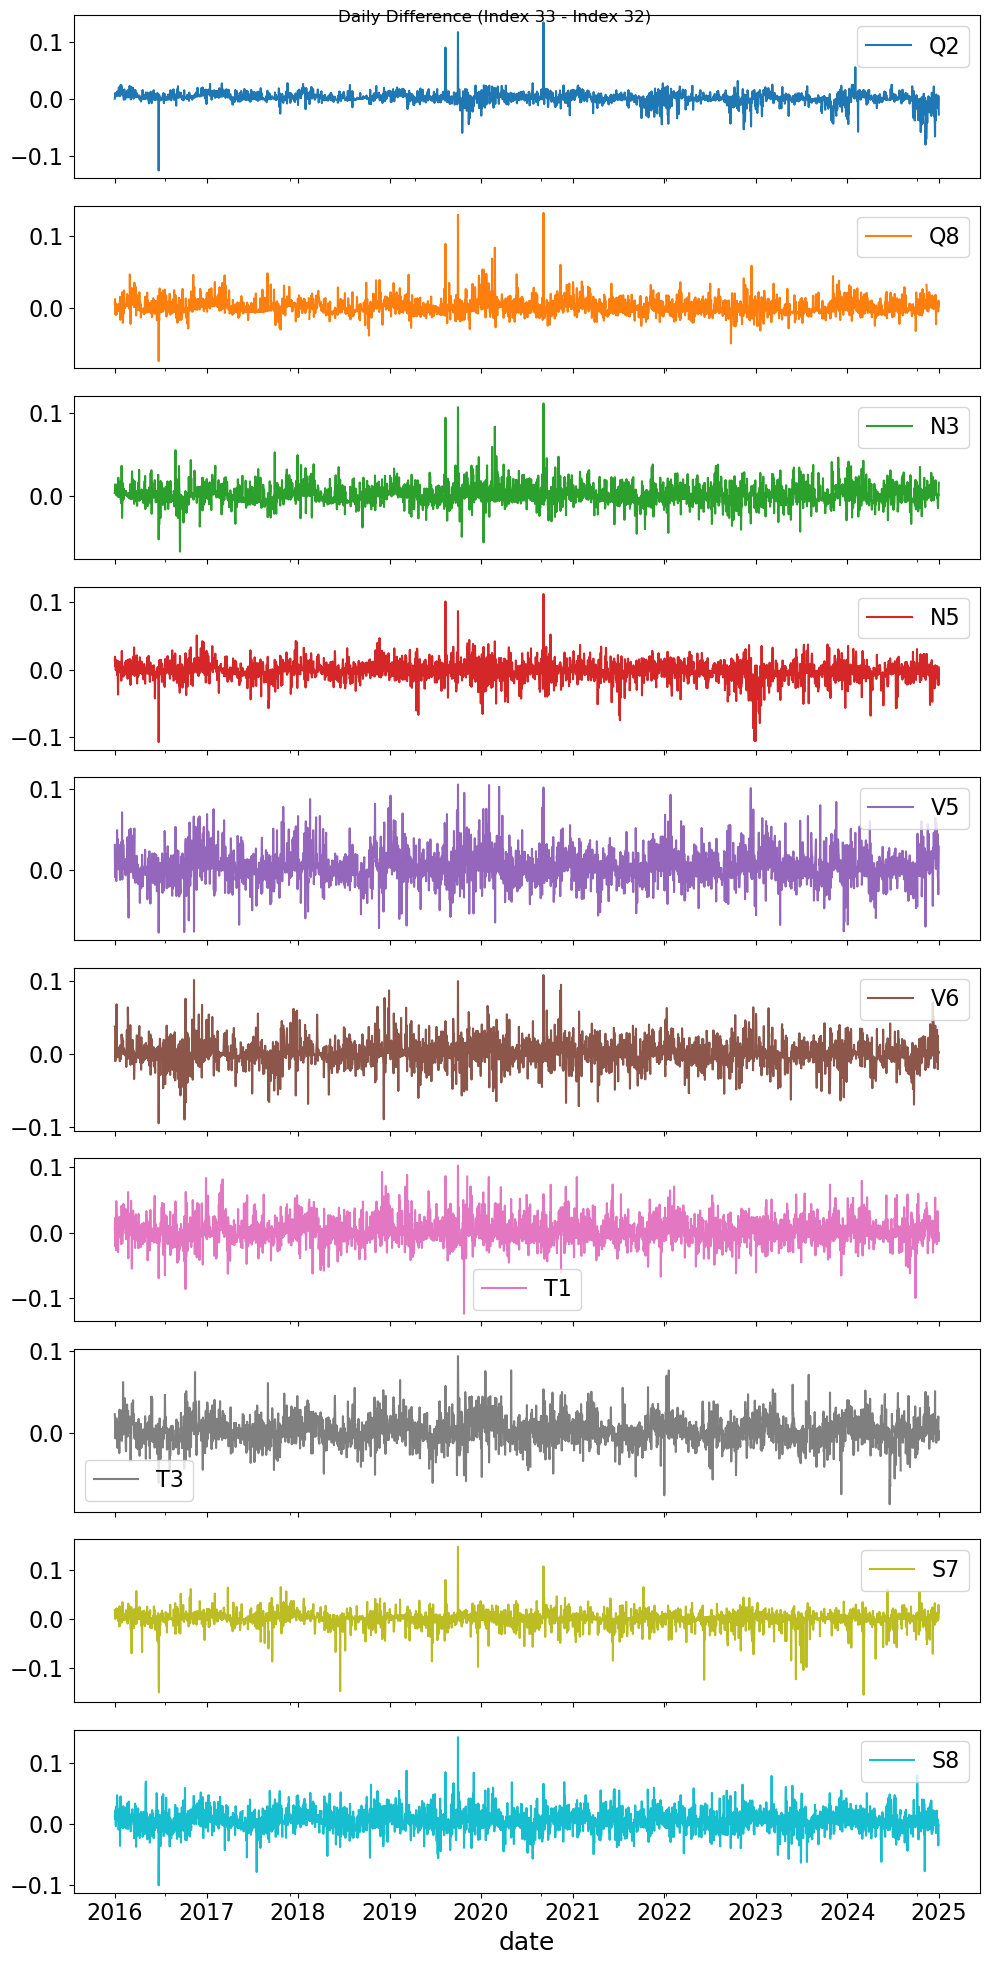

In [16]:
# Plot each variable
diff_df.plot(subplots=True,
             figsize=(10, len(diff_df.columns) * 2),
             title="Daily Difference (Index 33 - Index 32)",
             # ylim=(0,0.1)
            )
plt.tight_layout()
plt.show()

In [106]:
for reg in regions:
    max_ = ds_aus[reg].max().data
    print(reg)
    print(ds_aus[reg][ds_aus[reg] == max_].time.data)

Q2
['2019-10-01T10:20:00.000000000']
Q8
['2024-12-24T11:00:00.000000000']
N3
['2018-01-16T10:10:00.000000000']
N5
['2020-01-02T10:40:00.000000000']
V5
['2022-12-19T11:30:00.000000000']
V6
['2019-12-22T10:40:00.000000000']
S7
['2020-01-02T11:50:00.000000000']
S8
['2020-01-01T11:00:00.000000000']
T1
['2019-12-22T10:00:00.000000000']
T3
['2018-12-30T10:00:00.000000000']


# Clip Dusk and Dawn

In [7]:
# REMOVE BAD DUSK AND DAWN DATA
for state in regions:
    ds_aus[state] = solar_plotting.clip_dusk_dawn(ds_aus[state], n=6)

# Make a combined "total" variable to represent all regions

In [8]:
stacked = xr.concat([ds_aus[var] for var in ds_aus.data_vars], dim="region")

total = stacked.mean(dim="region")

ds_aus["total"] = total

# Constant below threshold

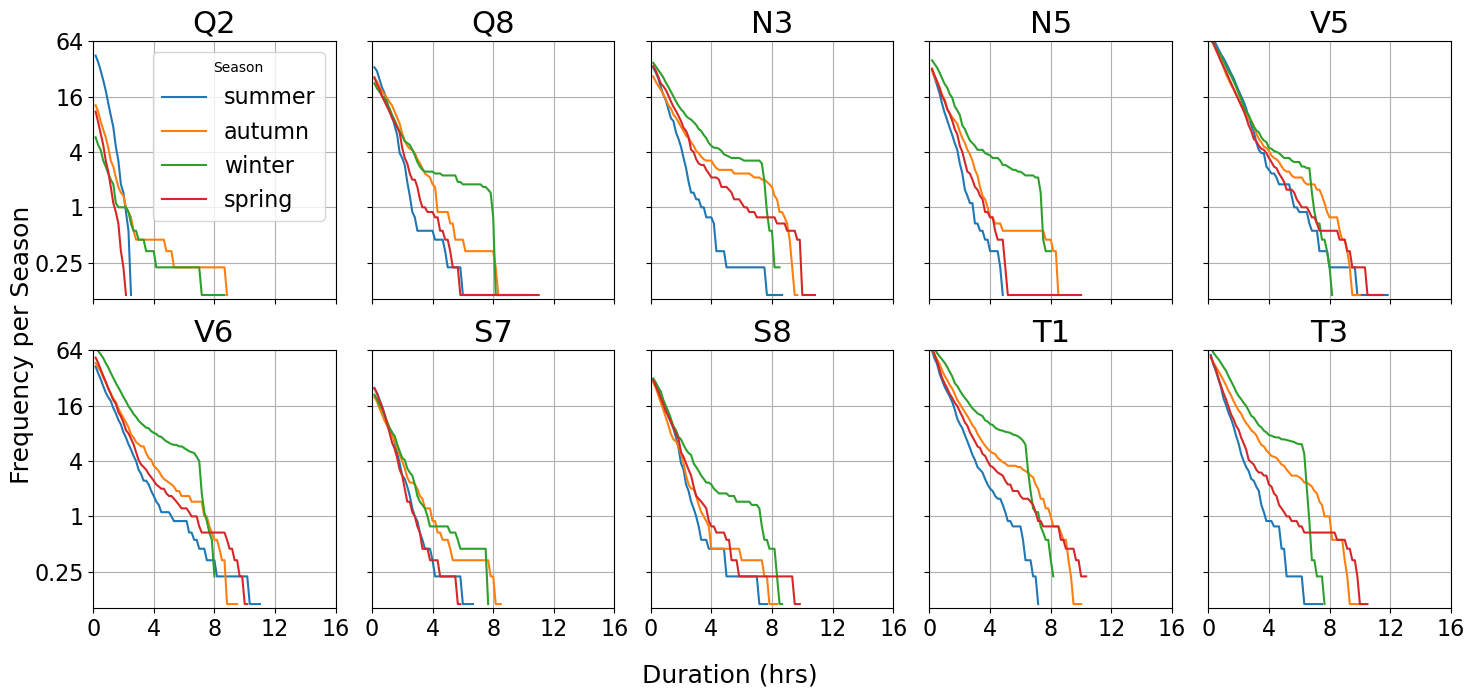

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 7), sharex=True, sharey=True)
ax = ax.flatten()

for i, reg in enumerate(regions):
    cbt = solar_plotting.constant_below_threshold(da=ds_aus[reg], threshold=0.2)
    for season in cbt:
        x = np.array(cbt[season][0])
        y = np.array(cbt[season][1])
        ax[i].plot(x[y > 0], y[y > 0], label=season)
    ax[i].set_title(reg)
    ax[i].grid(True)

    # Set log scale and custom tick formatting for y-axis
    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

# Add legend only to the first subplot
ax[0].legend(title="Season")

# Axis limits and labels
plt.xlim(0, 16)
plt.xticks(range(0, 17, 4))
plt.ylim(0.1,64)
fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)

plt.tight_layout()
plt.show()

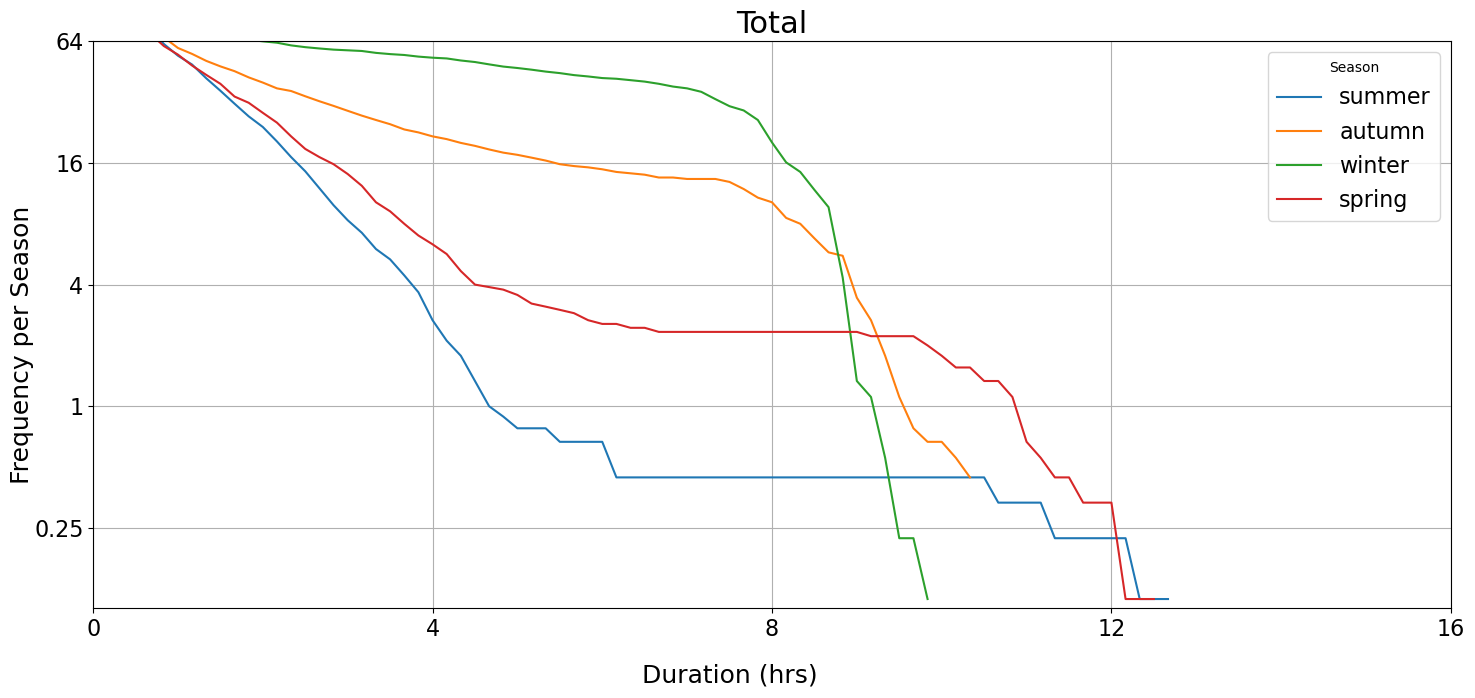

In [10]:
fig, ax = plt.subplots(figsize=(15, 7), sharex=True, sharey=True)


cbt = solar_plotting.constant_below_threshold(da=ds_aus.total, threshold=0.5)
for season in cbt:
    x = np.array(cbt[season][0])
    y = np.array(cbt[season][1])
    ax.plot(x[y > 0], y[y > 0], label=season)
ax.set_title("Total")
ax.grid(True)

# Set log scale and custom tick formatting for y-axis
ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

# Add legend only to the first subplot
ax.legend(title="Season")

# Axis limits and labels
plt.xlim(0, 16)
plt.xticks(range(0, 17, 4))
plt.ylim(0.1,64)
fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)

plt.tight_layout()
plt.show()

# Mean Below Threshold

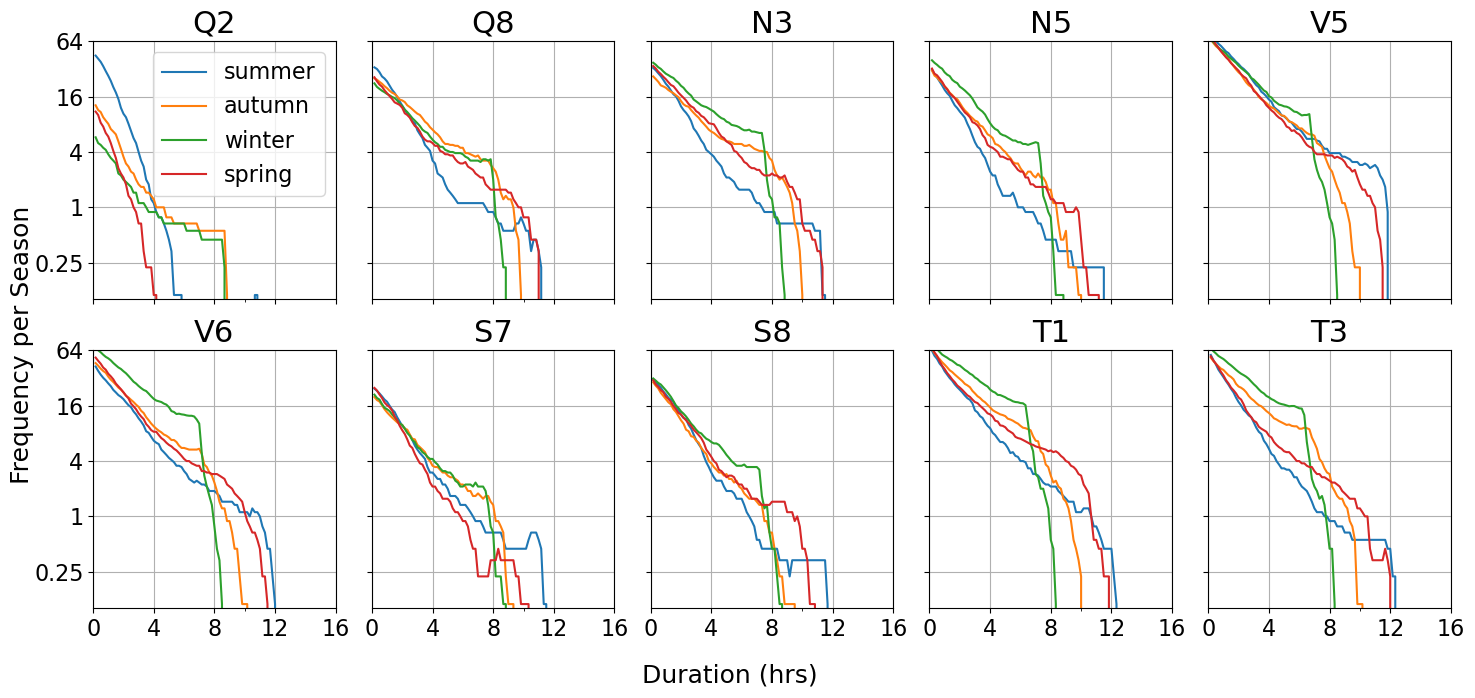

In [11]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True)
ax=ax.flatten()

for i, reg in enumerate(regions):
    mbt = solar_plotting.mean_below_threshold(da=ds_aus[reg], threshold=0.2, max_hours=16)
    mbt.plot(ax=ax[i])
    ax[i].set_title(reg, rotation=0)
    ax[i].set_xlabel('')
    ax[i].legend().remove()
    ax[i].grid(True)

    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))


if len(regions) % 2 == 1:
    ax[i].axis('off')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend(handles, labels, loc="center", frameon=False, title="Season")
else:
    ax[0].legend()


fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)
plt.xlim(0,16)
plt.xticks(range(0,17, 4))
plt.ylim(0.1,64)
plt.tight_layout()
plt.show()

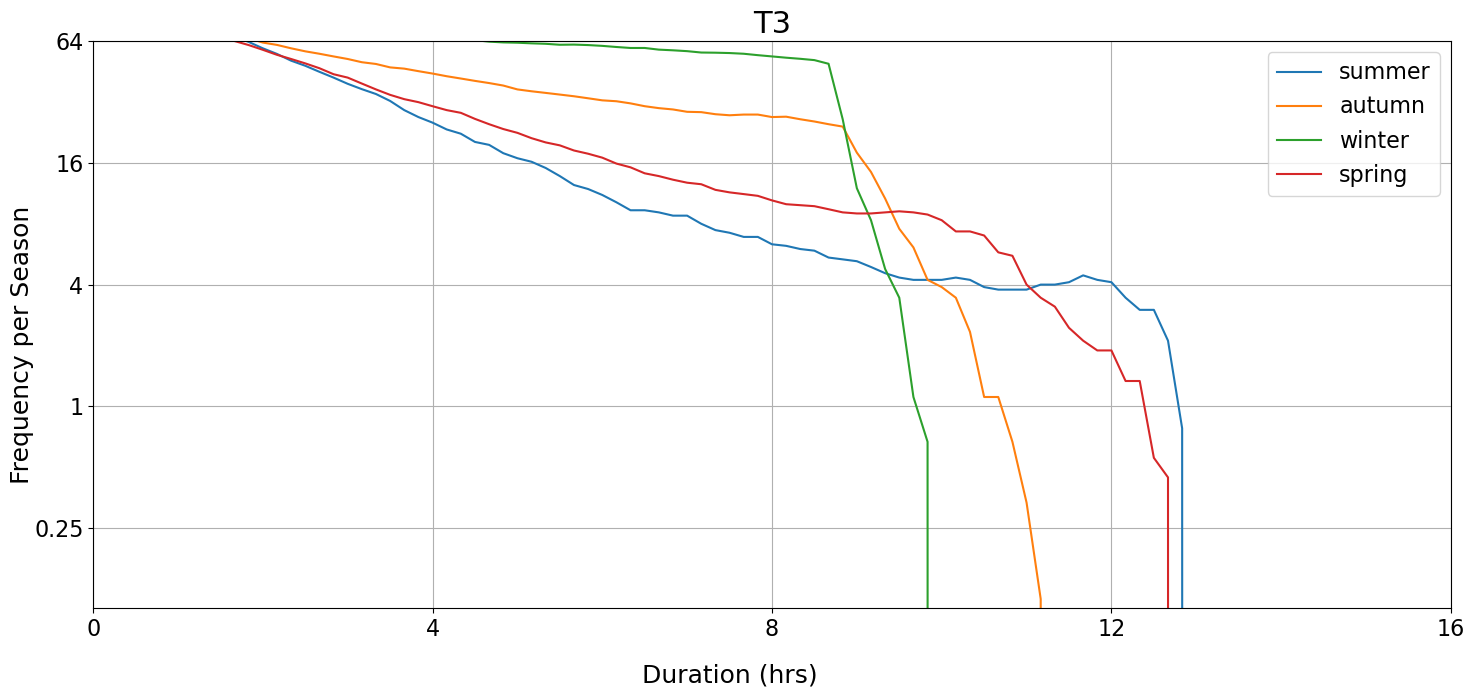

In [12]:
fig, ax = plt.subplots(figsize=(15,7), sharex=True, sharey=True)

mbt = solar_plotting.mean_below_threshold(da=ds_aus.total, threshold=0.5, max_hours=16)
mbt.plot(ax=ax)
ax.set_title(reg, rotation=0)
ax.set_xlabel('')
ax.legend().remove()
ax.grid(True)

ax.set_yscale('log', base=2)
ax.yaxis.set_major_locator(LogLocator(base=2.0))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))


if len(regions) % 2 == 1:
    ax.axis('off')
    handles, labels = ax[0].get_legend_handles_labels()
    ax.legend(handles, labels, loc="center", frameon=False, title="Season")
else:
    ax.legend()


fig.supxlabel('Duration (hrs)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)
plt.xlim(0,16)
plt.xticks(range(0,17, 4))
plt.ylim(0.1,64)
plt.tight_layout()
plt.show()

# Multi-Day Droughts

/home/548/cd3022/aus-historical-solar-droughts/modules/solar_plotting.py:144: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  temp_da = xr.DataArray(res, coords={'time': dates}, dims='time')
/home/548/cd3022/aus-historical-solar-droughts/modules/solar_plotting.py:144: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 v

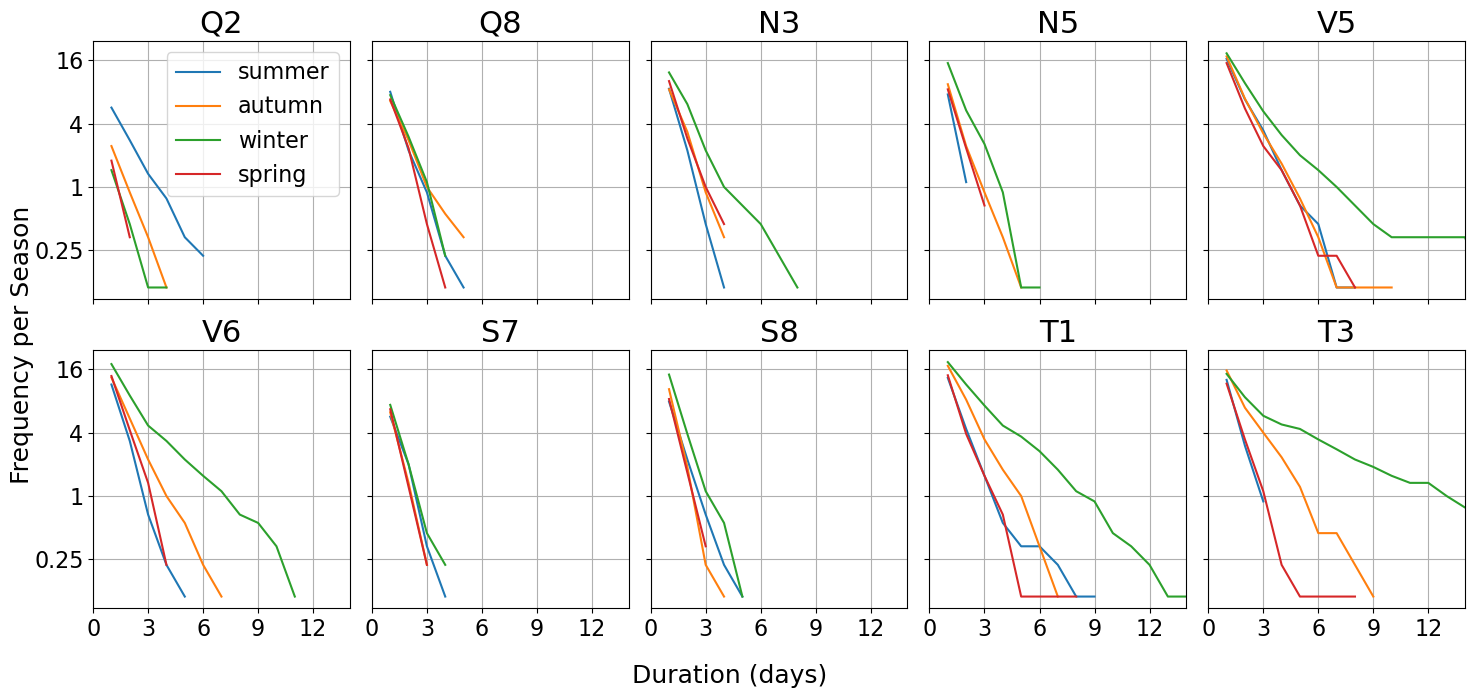

In [13]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True)
ax=ax.flatten()

for i, reg in enumerate(regions):
    cbt = solar_plotting.daily_drought(
        da=ds_aus[reg], 
        threshold = 0.2,
        tot_time=12,
        max_len=6,
        day_mean=0.2,
        day_sum=15
    )
    for season in cbt:
        ax[i].plot(cbt[season][0], cbt[season][1], label=season)
    ax[i].set_title(reg)
    ax[0].legend()
    ax[i].grid(True)

    ax[i].set_yscale('log', base=2)
    ax[i].yaxis.set_major_locator(LogLocator(base=2.0))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{int(y)}" if y >= 1 else f"{y:.2f}"))

if len(regions) % 2 == 1:
    ax[i].axis('off')
    handles, labels = ax[0].get_legend_handles_labels()
    ax[i].legend(handles, labels, loc="center", frameon=False, title="Season")
else:
    ax[0].legend()

fig.supxlabel('Duration (days)', fontsize=18)
fig.supylabel('Frequency per Season', fontsize=18)
plt.xlim(0,14)
plt.xticks(range(0, 14, 3))
plt.tight_layout()
plt.show()

# Day/time Heatmap

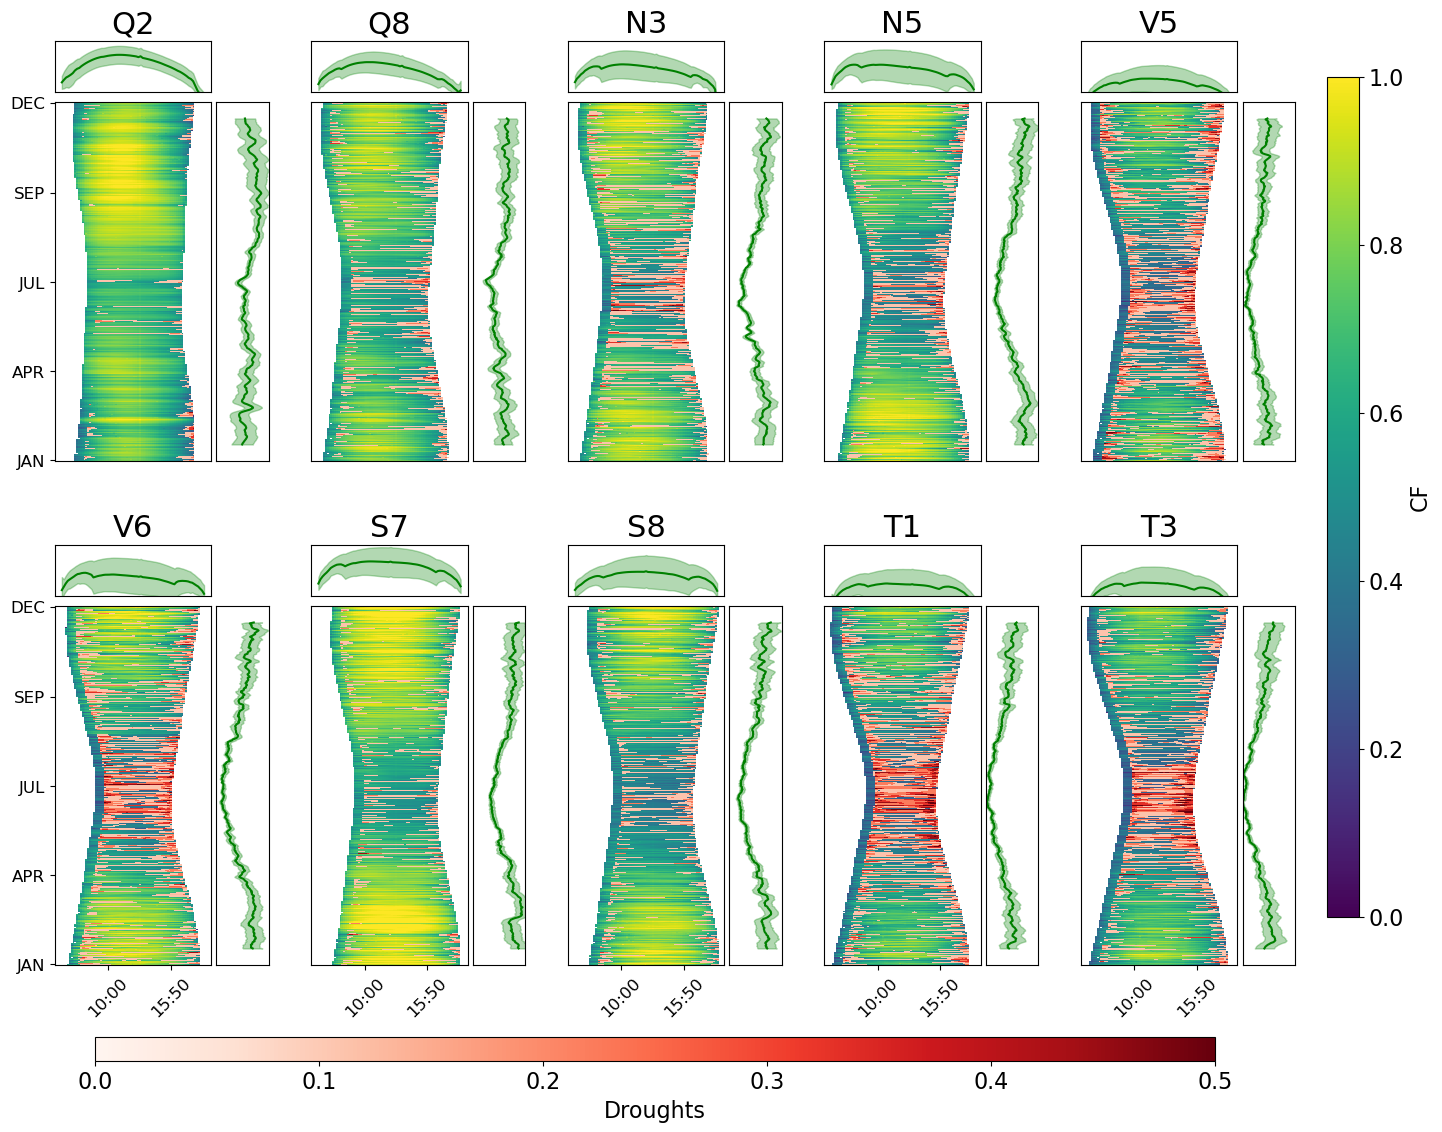

In [14]:
fig = plt.figure(figsize=(16, 12))
outer_gs = gridspec.GridSpec(nrows=2, ncols=ncols, figure=fig)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar_droughts_ax = fig.add_axes([0.15, 0.03, 0.7, 0.02])

# Create the colormap once
cmap = plt.cm.viridis.copy()
cmap_droughts = plt.cm.Reds.copy()
cmap.set_bad(color='white')
cmap_droughts.set_bad(color='none')
im = None
im_droughts = None

for idx, reg in enumerate(regions):
    row, col = divmod(idx, ncols)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 2,
        subplot_spec=outer_gs[row, col],
        width_ratios=[3, 1],
        height_ratios=[1, 7],
        wspace=0.05,
        hspace=0.05
    )

    # Sub-axes
    ax_heatmap = fig.add_subplot(inner_gs[1, 0])
    ax_top = fig.add_subplot(inner_gs[0, 0])#, sharex=ax_heatmap)
    # ax_top_secondary = ax_top.twinx()
    ax_right = fig.add_subplot(inner_gs[1, 1])#, sharey=ax_heatmap)
    # ax_right_secondary = ax_right.twiny()
    ax_legend = fig.add_subplot(inner_gs[0, 1])
    ax_legend.axis('off')

    df = solar_plotting.day_time_df(ds_aus[reg])
    df = df.drop(df.columns[49], axis=1)

    df_droughts = solar_plotting.day_time_droughts(ds_aus[reg], threshold = 0.2, time=6)
    df_droughts = df_droughts.drop(df_droughts.columns[49], axis=1)
    df_droughts[df_droughts == 0] = np.nan
    alpha = np.where(np.isnan(df_droughts), 0, 1)

    im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')
    im_droughts = ax_heatmap.imshow(df_droughts, aspect="auto", origin="lower", cmap=cmap_droughts, vmin=0, vmax=0.5, interpolation='none')

    # Axis ticks
    xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
    xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    ax_heatmap.set_xticks(xticks)
    ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)
    if idx < 5:
        ax_heatmap.set_xticks([])

    if idx in [0, 5]:
        yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
        ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b").upper() for j in yticks]
        ax_heatmap.set_yticks(yticks)
        ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)
    else:
        ax_heatmap.set_yticks([])

    ax_heatmap.set_xlim(4,89)

    # Top line plots
    mean_daily = df.mean(axis=0)
    std_daily = df.std(axis=0)
    
    # Plot the mean line
    line1, = ax_top.plot(mean_daily.values, color="green", label='Mean (daily)')
    ax_top.fill_between(
        np.arange(len(mean_daily)), 
        mean_daily - std_daily, 
        mean_daily + std_daily, 
        color="green", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_top.tick_params(axis='x', labelbottom=False)
    ax_top.set_yticks([])
    ax_top.set_xticks([])
    ax_top.set_ylim(0.4,1)
    ax_top.set_title(reg)

    # Right line plots
    mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    y = np.arange(df.shape[0])
    line3, = ax_right.plot(mean_weekly.values, y, color="green", label='Mean (annual)')
    # Shade ±1 std dev horizontally
    ax_right.fill_betweenx(
        y, 
        mean_weekly - std_weekly, 
        mean_weekly + std_weekly, 
        color="green", 
        alpha=0.3, 
        label='±1 Std Dev'
    )

    ax_right.tick_params(axis='y', labelleft=False)
    ax_right.set_xticks([])
    ax_right.set_yticks([])
    ax_right.set_xlim(0.25, 1)

fig.colorbar(im, cax=cbar_ax).set_label('CF', fontsize=16)
fig.colorbar(im_droughts, cax=cbar_droughts_ax, orientation='horizontal').set_label('Droughts', fontsize=16)
fig_path = f'{fig_dir}/heatmap'
os.makedirs(fig_path, exist_ok=True)
plt.savefig(f'{fig_path}/CF-day-time-avail.png')
plt.show()

In [15]:
# Inlcude overnight 0 values for load duration curve
def full_time(da):
    data = da.copy() 
    times = pd.date_range(data.time.values.min(), data.time.values.max(), freq='10min')
    data = data.reindex(time=times, fill_value=0)
    
    data['time'] = pd.to_datetime(data.time.values)
    hour = data['time'].dt.hour
    day_mask = (hour >= 9) & (hour <= 16)
    data = data.where(~(~day_mask & np.isnan(data)), 0)
    data = data.dropna(dim='time')
    return data

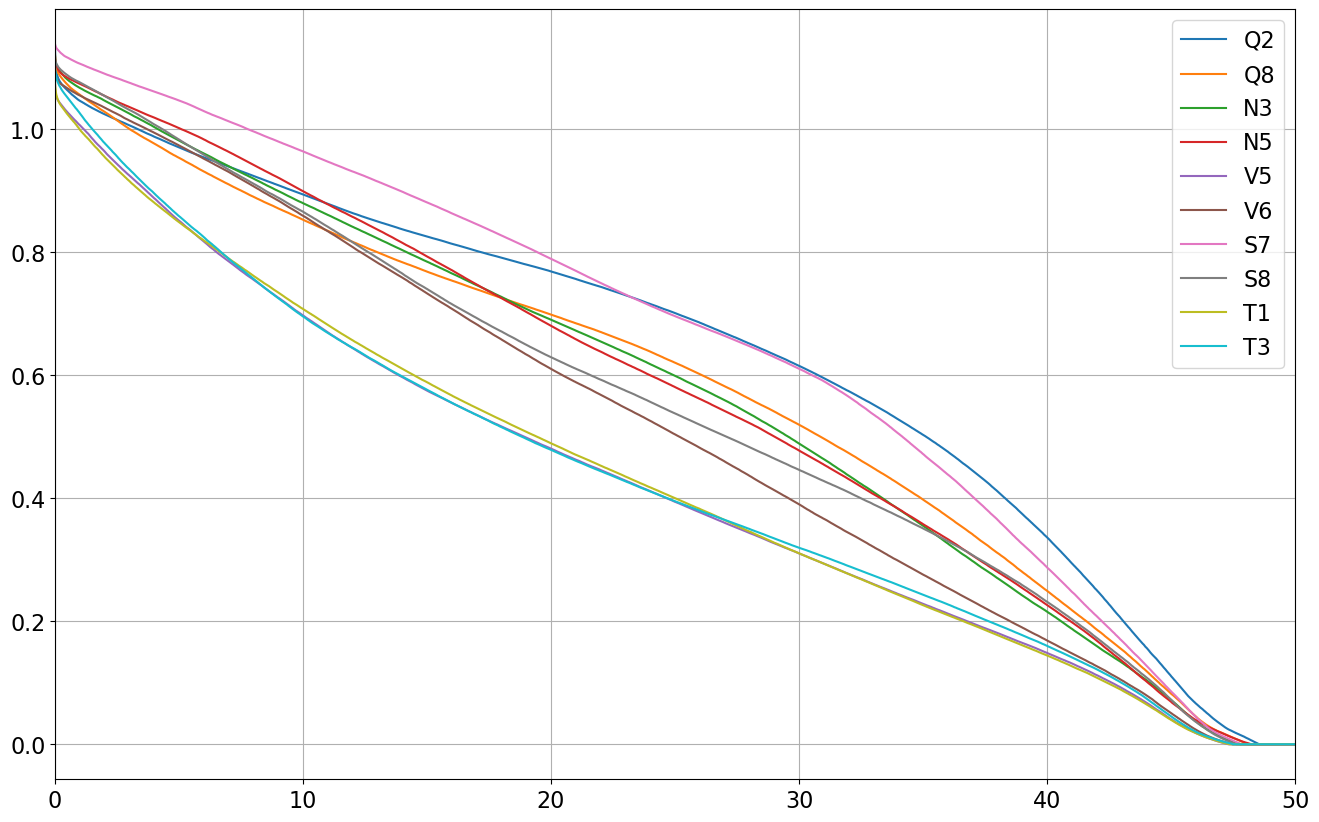

In [16]:
fig, ax = plt.subplots(figsize=(16, 10))
for r in regions:
    full_time_da = full_time(da=ds_raw[r])
    vals = np.sort(full_time_da.data)[::-1]
    percentiles = np.linspace(0,100,(len(vals)))
    ax.plot(percentiles, vals, label=r)
plt.legend()
# plt.axhline(0.2, color='r', linestyle='--')
# plt.xticks([0, 10, ])
plt.xlim(0,50)
plt.grid(True)

In [17]:
for reg in regions:
    daily_max = ds_aus[reg].resample(time='1D').max()
    anomalies = daily_max[daily_max > 1.1]
    print(anomalies.time.data)

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

['2016-01-06T00:00:00.000000000' '2016-11-15T00:00:00.000000000'
 '2016-11-16T00:00:00.000000000' '2017-12-05T00:00:00.000000000'
 '2018-11-30T00:00:00.000000000' '2019-02-12T00:00:00.000000000'
 '2019-10-01T00:00:00.000000000' '2019-10-20T00:00:00.000000000'
 '2019-11-09T00:00:00.000000000' '2019-11-10T00:00:00.000000000'
 '2020-09-06T00:00:00.000000000' '2020-10-29T00:00:00.000000000']
['2018-01-15T00:00:00.000000000' '2018-01-16T00:00:00.000000000'
 '2018-11-23T00:00:00.000000000' '2018-11-24T00:00:00.000000000'
 '2018-12-25T00:00:00.000000000' '2019-11-07T00:00:00.000000000'
 '2019-11-09T00:00:00.000000000' '2019-11-14T00:00:00.000000000'
 '2019-12-04T00:00:00.000000000' '2019-12-05T00:00:00.000000000'
 '2019-12-06T00:00:00.000000000' '2021-12-11T00:00:00.000000000'
 '2022-12-14T00:00:00.000000000' '2022-12-15T00:00:00.000000000'
 '2024-12-24T00:00:00.000000000']
['2016-11-24T00:00:00.000000000' '2016-11-26T00:00:00.000000000'
 '2016-12-09T00:00:00.000000000' '2016-12-10T00:00:00.0

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


['2018-12-24T00:00:00.000000000' '2018-12-30T00:00:00.000000000'
 '2022-12-18T00:00:00.000000000']


In [18]:
for reg in regions:
    print(ds_aus[reg][ds_aus[reg] == ds_aus[reg].max()].time.data)

['2019-10-01T10:20:00.000000000']
['2024-12-24T11:00:00.000000000']
['2018-01-16T10:10:00.000000000']
['2020-01-02T10:40:00.000000000']
['2022-12-19T11:30:00.000000000']
['2019-12-22T10:40:00.000000000']
['2020-01-02T11:50:00.000000000']
['2020-01-01T11:00:00.000000000']
['2019-12-22T10:00:00.000000000']
['2018-12-30T10:00:00.000000000']


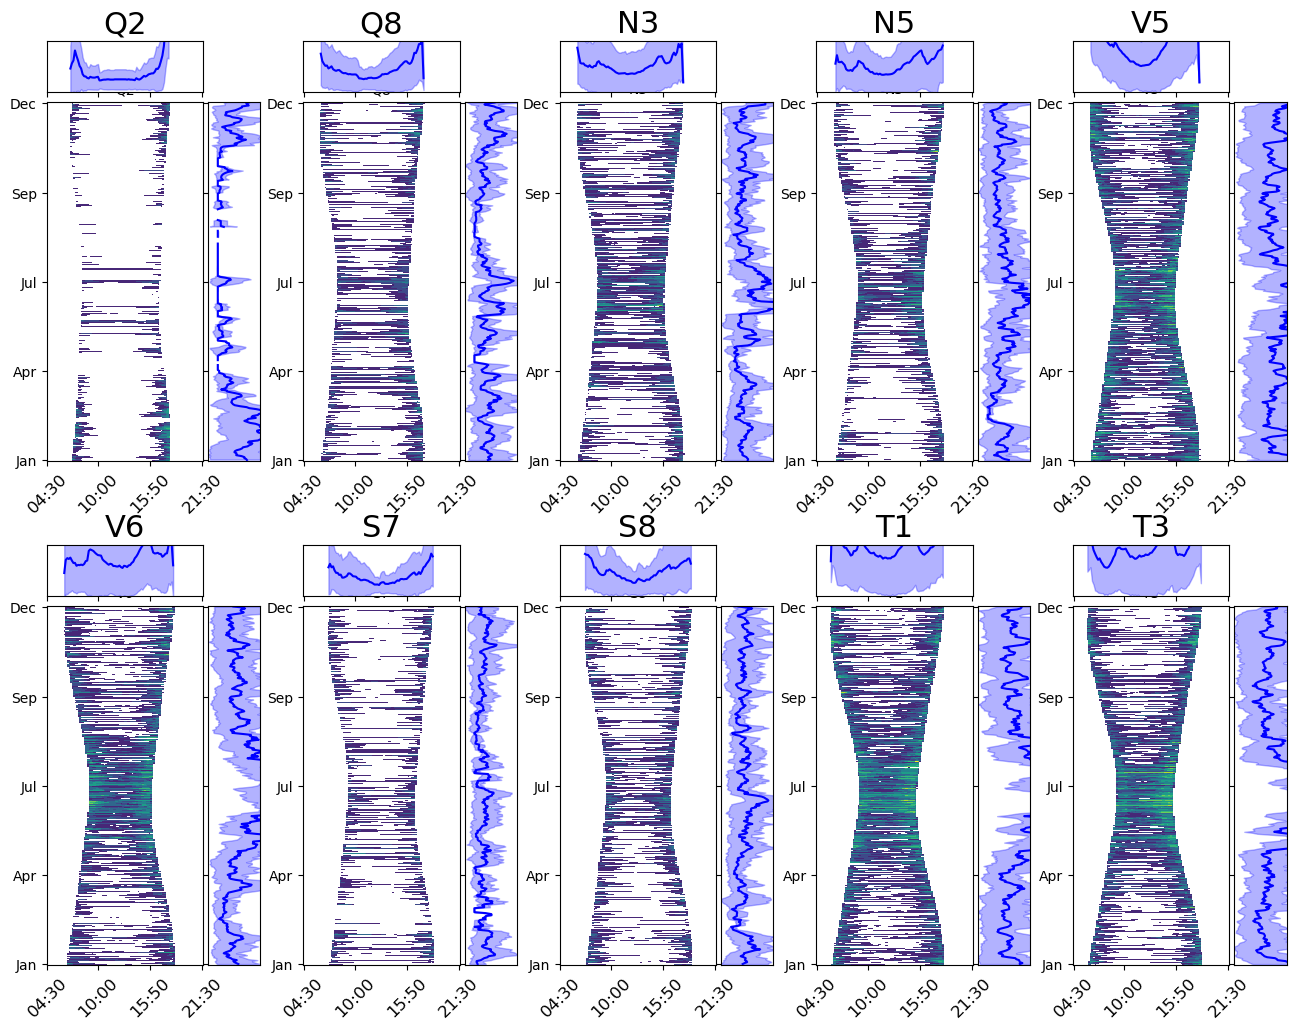

In [19]:
fig = plt.figure(figsize=(16, 12))
outer_gs = gridspec.GridSpec(nrows=2, ncols=ncols, figure=fig)

# Create the colormap once
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
im = None

for idx, reg in enumerate(regions):
    row, col = divmod(idx, ncols)
    inner_gs = gridspec.GridSpecFromSubplotSpec(2, 2,
        subplot_spec=outer_gs[row, col],
        width_ratios=[3, 1],
        height_ratios=[1, 7],
        wspace=0.05,
        hspace=0.05
    )

    # Sub-axes
    ax_heatmap = fig.add_subplot(inner_gs[1, 0])
    ax_top = fig.add_subplot(inner_gs[0, 0], sharex=ax_heatmap)
    # ax_top_secondary = ax_top.twinx()
    ax_right = fig.add_subplot(inner_gs[1, 1], sharey=ax_heatmap)
    # ax_right_secondary = ax_right.twiny()
    ax_legend = fig.add_subplot(inner_gs[0, 1])
    ax_legend.axis('off')

    df = solar_plotting.day_time_droughts(ds_aus[reg], threshold = 0.25, time=2)
    df = df.drop(df.columns[49], axis=1)
    df[df == 0] = np.nan

    # Heatmap
    im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')
    ax_heatmap.set_title(reg, fontsize=10)

    # Axis ticks
    xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
    xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
    ax_heatmap.set_xticks(xticks)
    ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

    yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
    ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
    ax_heatmap.set_yticks(yticks)
    ax_heatmap.set_yticklabels(ytick_labels, fontsize=10)

    # Top line plots
    mean_daily = df.mean(axis=0)
    std_daily = df.std(axis=0)
    line1, = ax_top.plot(mean_daily.values, color="blue", label='Mean (daily)')
    ax_top.fill_between(
        np.arange(len(mean_daily)), 
        mean_daily - std_daily, 
        mean_daily + std_daily, 
        color="blue", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_top.tick_params(axis='x', labelbottom=False)
    ax_top.set_yticks([])
    ax_top.set_ylim(0.08,0.25)
    ax_top.set_title(reg)

    # Right line plots
    mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
    y = np.arange(df.shape[0])
    line3, = ax_right.plot(mean_weekly.values, y, color="blue", label='Mean (annual)')
    ax_right.fill_betweenx(
        y, 
        mean_weekly - std_weekly, 
        mean_weekly + std_weekly, 
        color="blue", 
        alpha=0.3, 
        label='±1 Std Dev'
    )
    ax_right.tick_params(axis='y', labelleft=False)
    ax_right.set_xticks([])
    ax_right.set_xlim(0.08, 0.25)

fig.colorbar(im, cax=cbar_ax).set_label('Solar Irradiance (normalized)', fontsize=12)
plt.show()

# Day/Year Heatmap

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

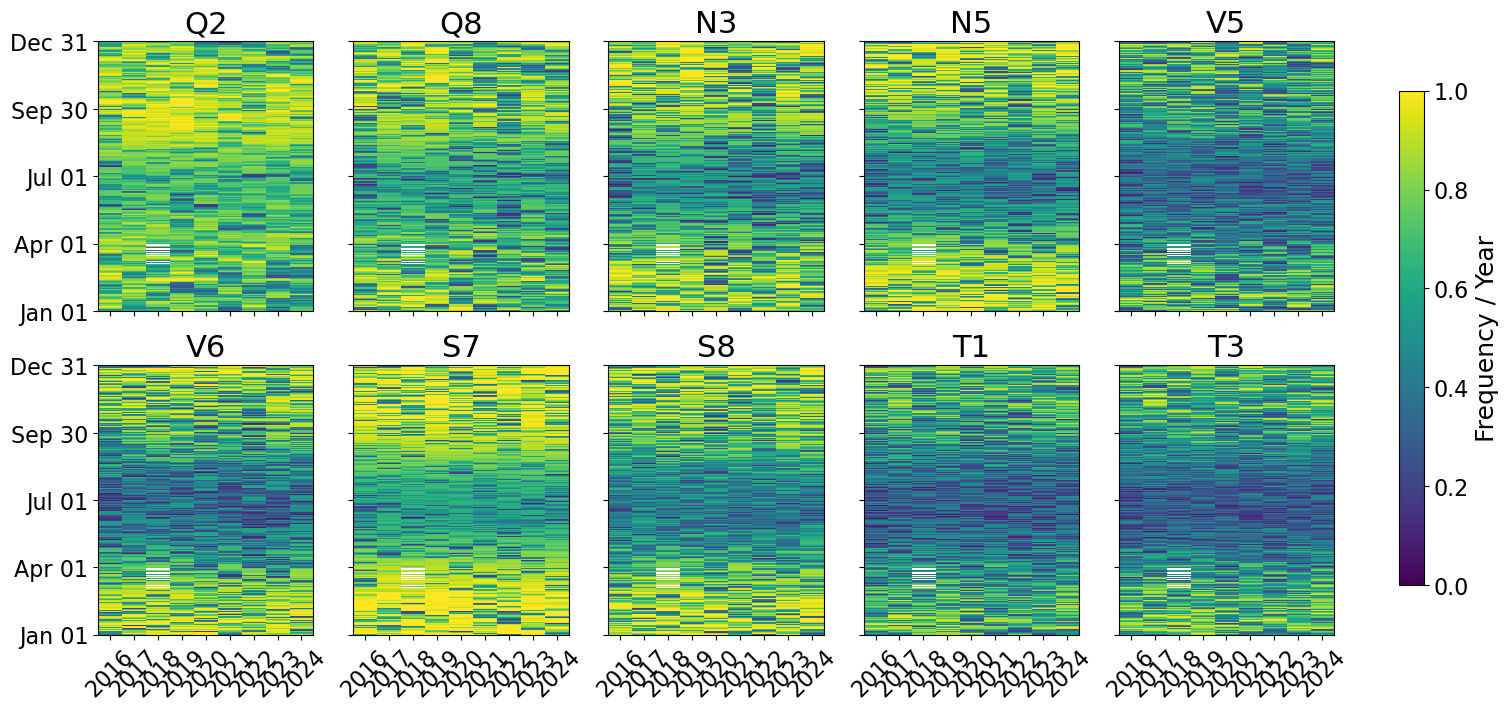

In [20]:
fig, ax = plt.subplots(nrows = 2, ncols = ncols, figsize=(15,7), sharex=True, sharey=True, constrained_layout=True)
ax = ax.flatten()
daily = ds_aus.resample(time="1D").mean()

cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')
im = None
for i, reg in enumerate(regions):
    df = solar_plotting.day_year_df(daily[reg])

    cmap = plt.cm.viridis
    cmap.set_bad(color='white')
    im = ax[i].imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=1, interpolation='none')
    ax[i].set_title(reg)
    xticks = np.arange(len(df.columns))
    xtick_labels = df.columns.astype(str)
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(xtick_labels, rotation=45)
    
    # Y-axis (Convert Day of Year → Month-Day)
    yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)  # Select 10 evenly spaced day labels
    ytick_labels = [(pd.Timestamp(f"2024-01-01") + pd.Timedelta(days=int(df.index[i]) - 1)).strftime("%b %d") for i in yticks]
    ax[i].set_yticks(yticks, ytick_labels)
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Frequency / Year', fontsize=18)

plt.show()

# Coincident Droughts

In [74]:
threshold = 0.2 # consistent threshold for all data below

# array showing the number of regions in "drought" for each timestep
coincident_droughts = np.zeros(len(ds_aus.time))
for reg in regions:
    drought_data = xr.where(ds_aus[reg] < threshold, 1, 0).values
    coincident_droughts += drought_data
coincident_da = xr.DataArray(coincident_droughts, dims=ds_aus.dims, coords=ds_aus.coords)

hourly_rolling = ds_aus.rolling(time=6, center=False).mean()
coincident_droughts_hourly = np.zeros(len(hourly_rolling.time))
for reg in regions:
    drought_data = xr.where(hourly_rolling[reg] < threshold, 1, 0).values
    coincident_droughts_hourly += drought_data
coincident_da_hourly = xr.DataArray(coincident_droughts_hourly, dims=hourly_rolling.dims, coords=hourly_rolling.coords)

# array for the number of regions in "drought" based on daily average
daily = ds_aus.resample(time="1D").mean()
coincident_droughts_daily = np.zeros(len(daily.time))
for reg in regions:
    drought_data = xr.where(daily[reg] < threshold, 1, 0).values
    coincident_droughts_daily += drought_data
coincident_da_daily = xr.DataArray(coincident_droughts_daily, dims=daily.dims, coords=daily.coords)

# dataset of boolean vals showing if each region is in drought
coincident_drought_ds = ds_aus < threshold

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _va

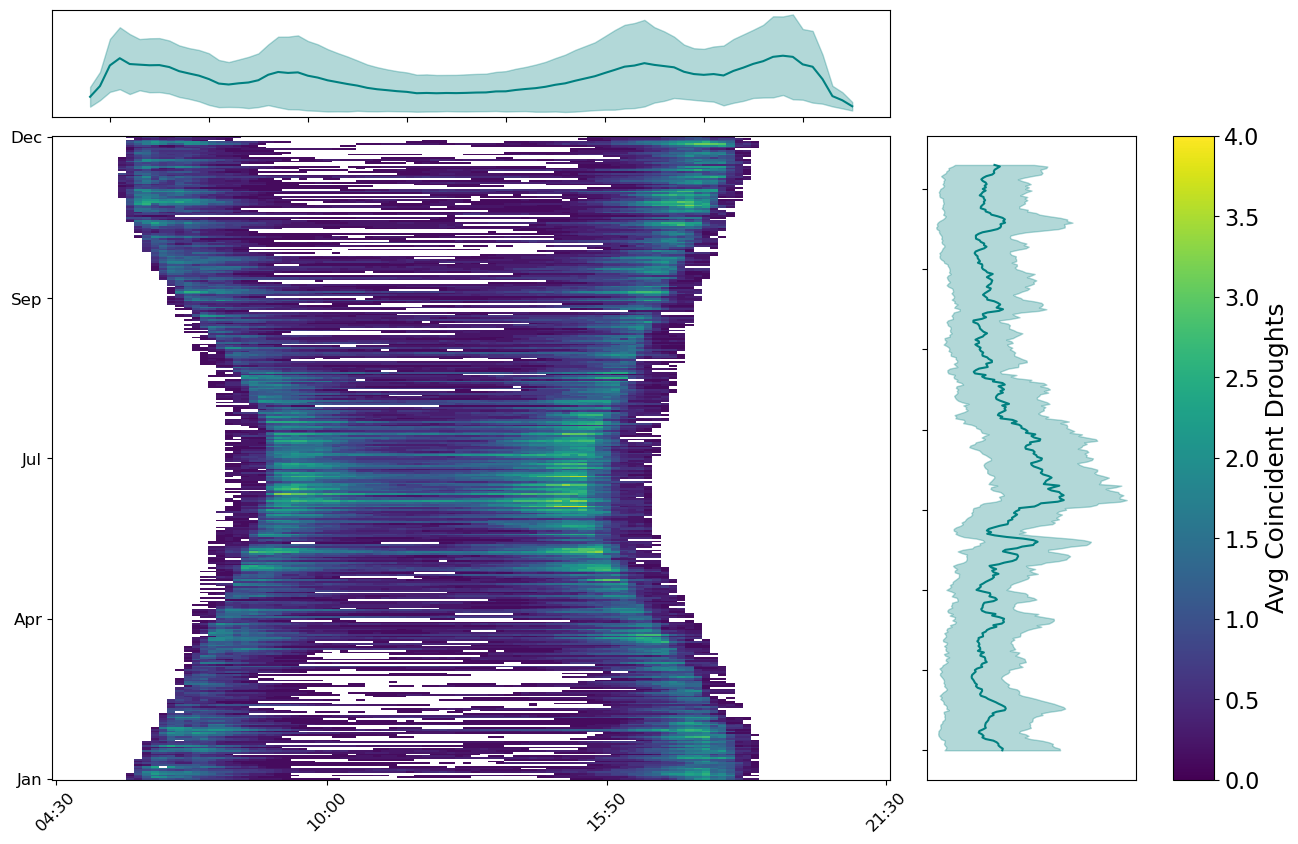

In [22]:
# Prepare data
df = solar_plotting.day_time_df(coincident_da)
df = df.drop(df.columns[49], axis=1)
df[df == 0] = np.nan

# Create the figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 3,  # 3 columns: [left (plots), right lineplot, colorbar]
    width_ratios=[4, 1, 0.2],  # Adjust third column for cbar
    height_ratios=[1, 6],
    wspace=0.1,
    hspace=0.05
)

# Create axes
ax_top = fig.add_subplot(gs[0, 0])        # top line plot
ax_heatmap = fig.add_subplot(gs[1, 0])    # main heatmap
ax_right = fig.add_subplot(gs[1, 1])  # right line plot
cbar_ax = fig.add_subplot(gs[1, 2]) 

# Colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Heatmap
im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=4, interpolation='none')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Avg Coincident Droughts', fontsize=18)

# Axis ticks - x
xticks = np.linspace(0, len(df.columns) - 1, 4, dtype=int)
xtick_labels = [df.columns[j].strftime("%H:%M") for j in xticks]
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=45, fontsize=12)

# Axis ticks - y
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
ax_heatmap.set_yticks(yticks)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)

# Top plot (mean and std across days for each time of day)
mean_daily = df.mean(axis=0)
std_daily = df.std(axis=0)
ax_top.plot(mean_daily.values, color='teal')
ax_top.fill_between(
    np.arange(len(mean_daily)),
    mean_daily - std_daily,
    mean_daily + std_daily,
    color='teal',
    alpha=0.3
)
ax_top.tick_params(axis='x', labelbottom=False)
ax_top.set_yticks([])

# Right plot (mean and std across hours for each day of year)
mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
y = np.arange(df.shape[0])
ax_right.plot(mean_weekly.values, y, color="teal")
ax_right.fill_betweenx(
    y,
    mean_weekly - std_weekly,
    mean_weekly + std_weekly,
    color="teal",
    alpha=0.3
)
ax_right.tick_params(axis='y', labelleft=False)
ax_right.set_xticks([])

plt.show()

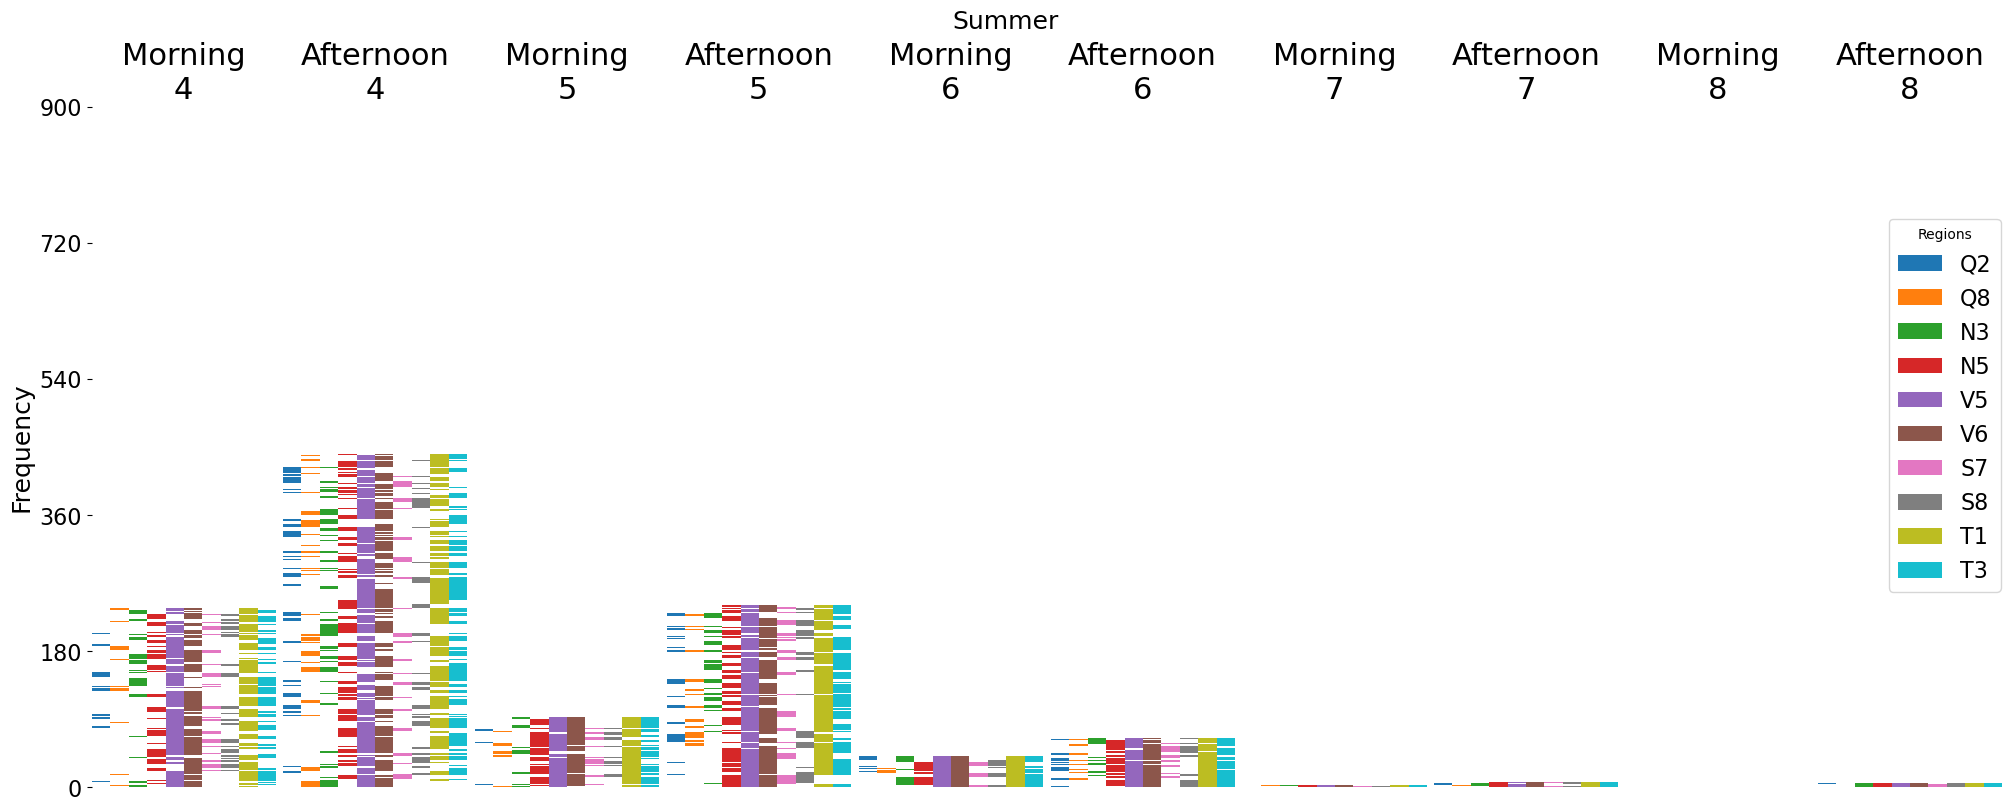

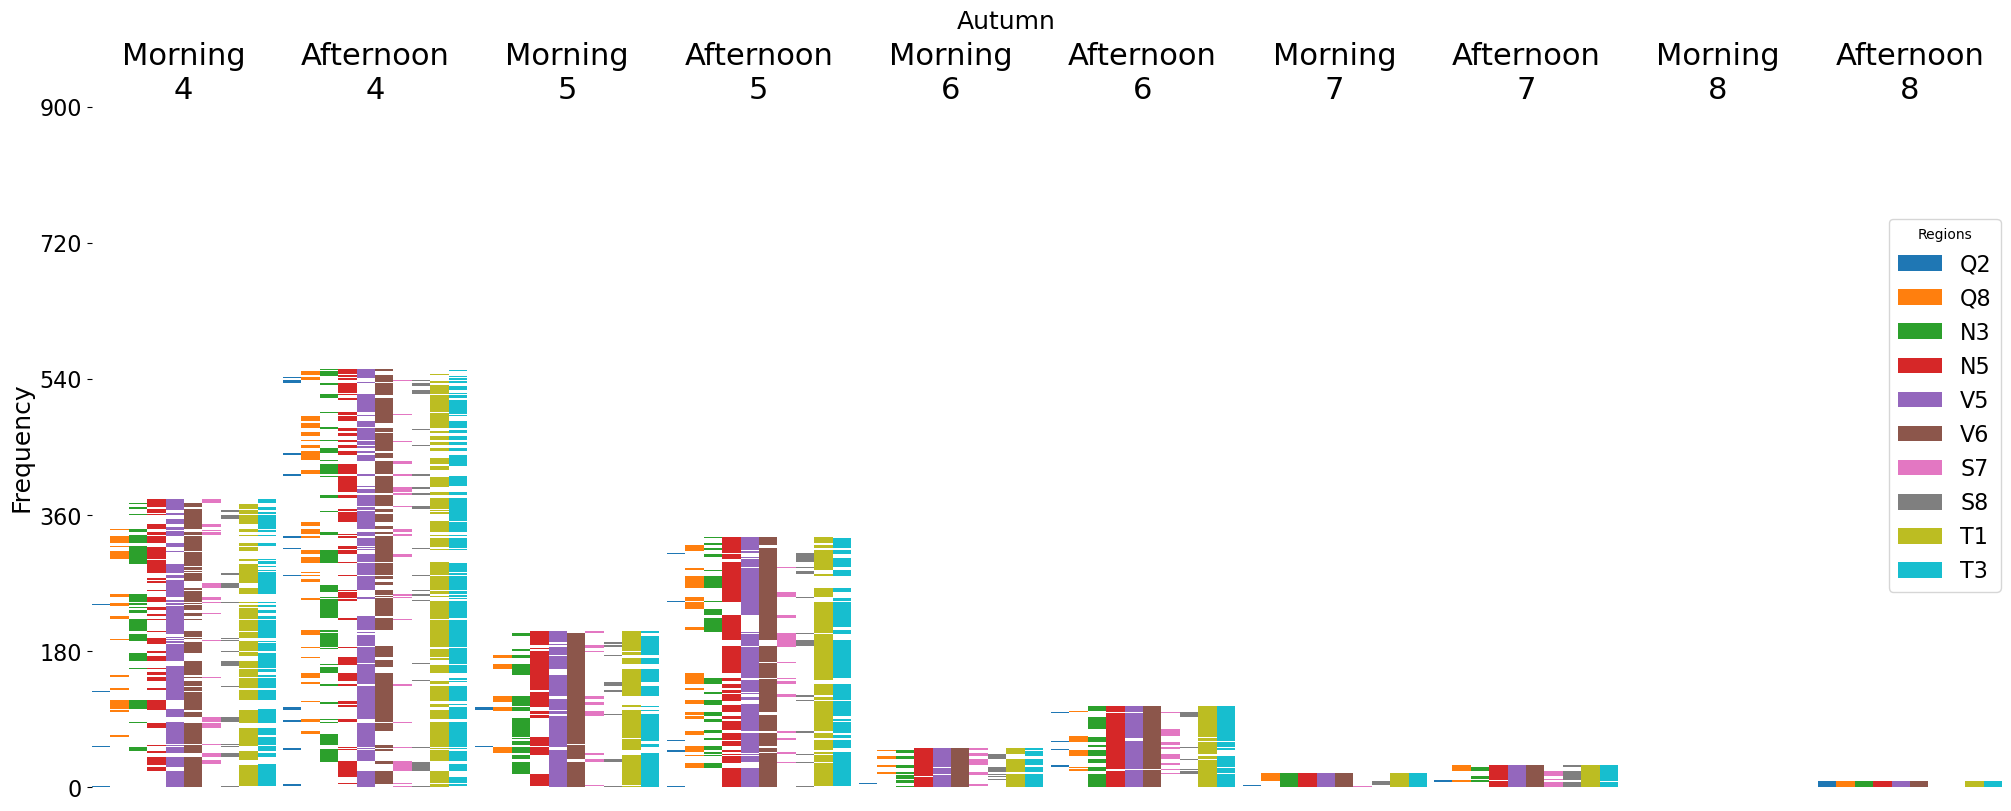

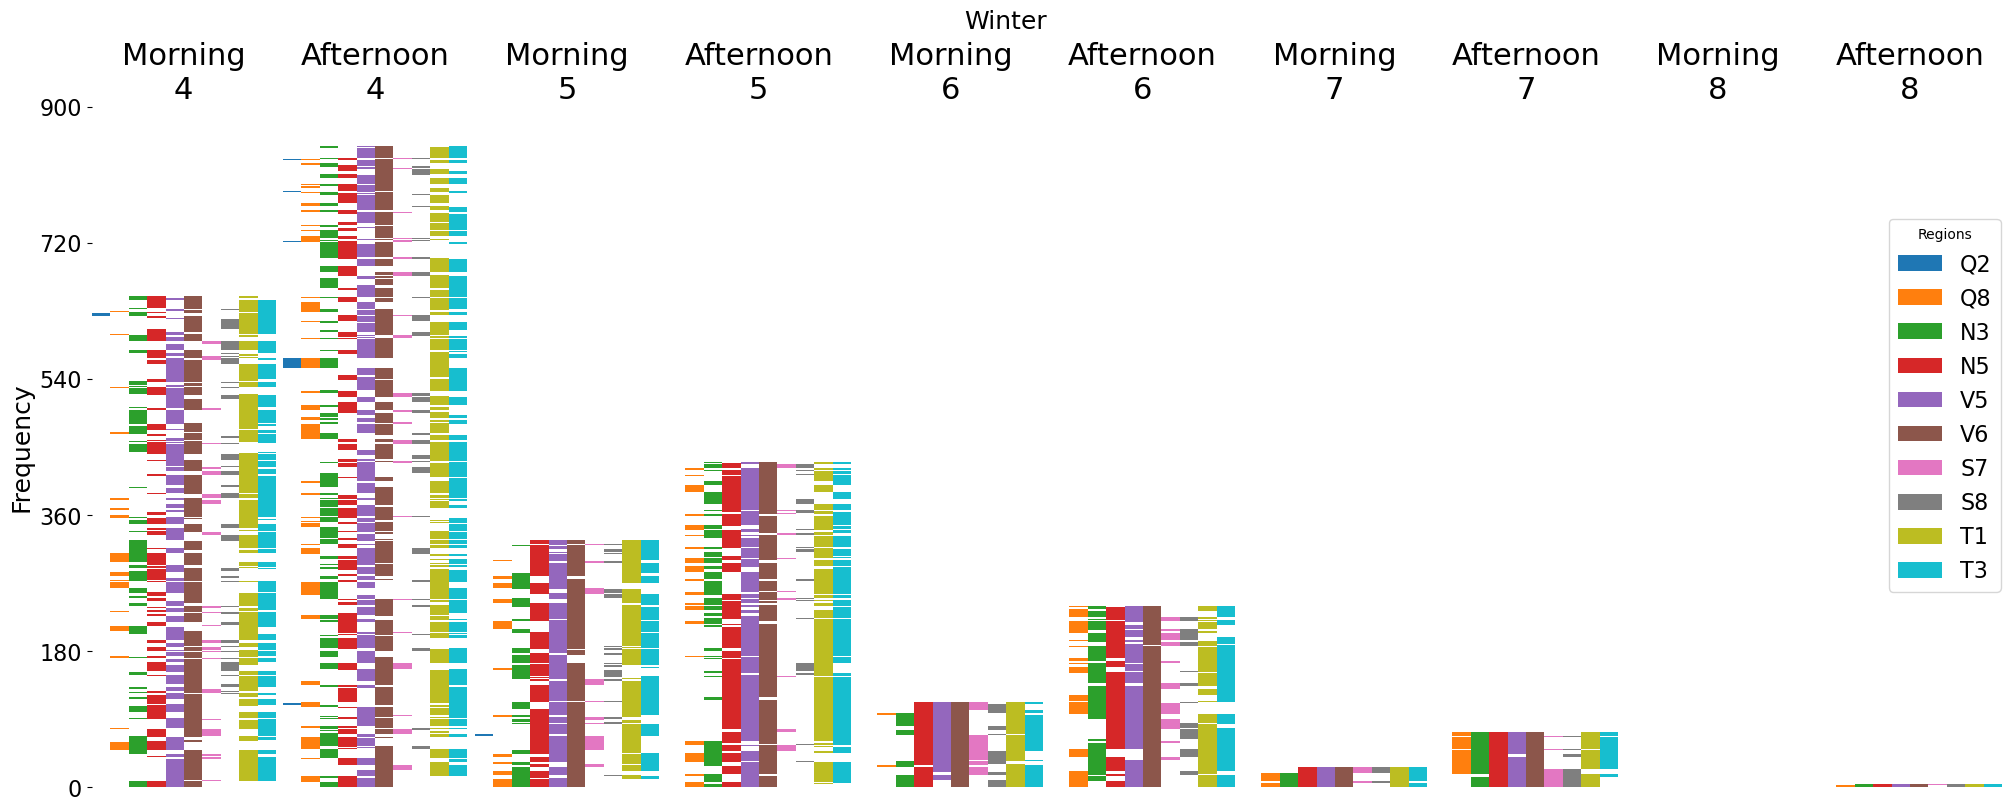

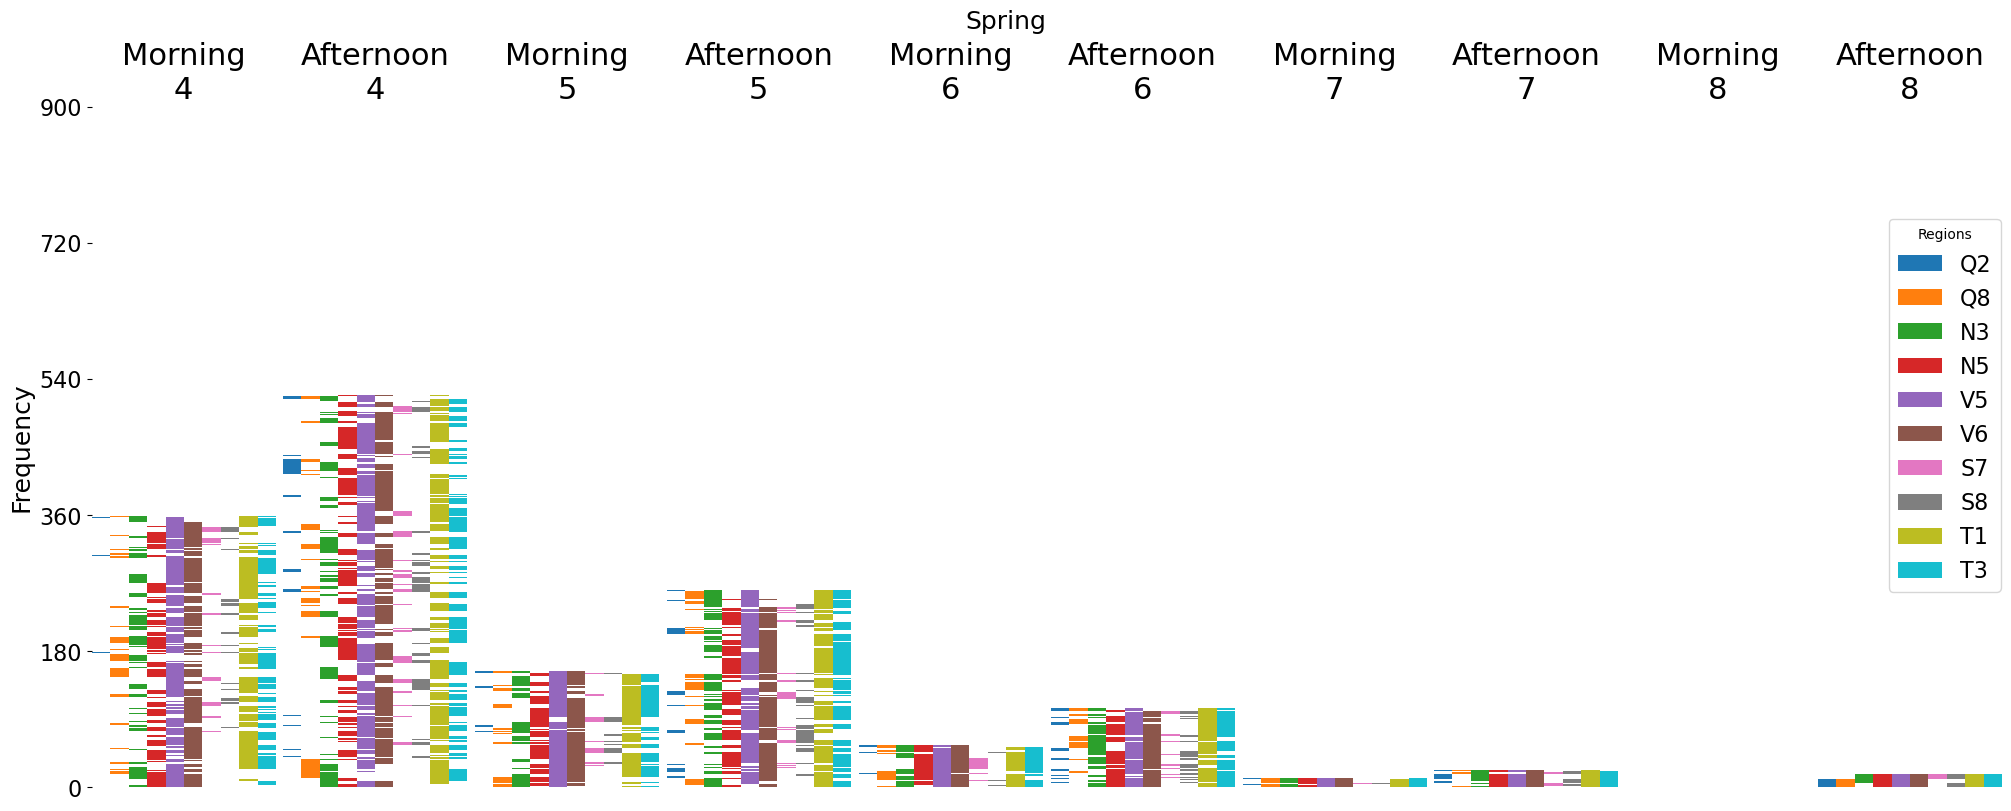

In [43]:
seasons = {
    'summer': [12, 1, 2],
    'autumn': [3, 4, 5],
    'winter': [6, 7, 8],
    'spring': [9, 10, 11]
}

for season in seasons:
    seasonal_data = coincident_da.where(coincident_da.time.dt.month.isin(seasons[season]), drop=True)
    morning_data = seasonal_data.where(seasonal_data.time.dt.hour < 12, drop=True)
    afternoon_data = seasonal_data.where(seasonal_data.time.dt.hour >= 12, drop=True)

    fig, axes = plt.subplots(
        nrows=1, ncols=10, figsize=(20, 8),
        constrained_layout=True
    )

    all_regions = list(regions)  # ensure legend includes all
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_regions)))[:, :3]

    i = 0
    for num_droughts in range(4, 9):
        for tod_label, time_of_day in zip(["Morning", "Afternoon"], [morning_data, afternoon_data]):
            times = time_of_day[time_of_day == num_droughts].time.data

            if len(times) == 0:
                axes[i].set_xticks([])
                axes[i].set_yticks([])
                axes[i].set_title(f"{tod_label}\n{num_droughts}")
                for spine in axes[i].spines.values():
                    spine.set_visible(False)
                i += 1
                continue

            # Build DataFrame
            data = {
                reg: coincident_drought_ds[reg].sel(time=times).data.astype(int)
                for reg in all_regions
            }
            df = pd.DataFrame(data, index=times)

            rgb_img = np.ones((len(df), len(df.columns), 3))
            for j, col in enumerate(df.columns):
                rgb_img[df[col].values == 1, j, :] = colors[j]

            axes[i].imshow(rgb_img, aspect='auto', interpolation='none')
            axes[i].set_title(f"{tod_label}\n{num_droughts}")
            axes[i].set_xticks([])
            axes[i].set_xticklabels([])
            axes[i].set_yticks([])
            ylim=900
            axes[0].set_yticks(np.linspace(0, ylim, 6, dtype=int))
            axes[0].set_ylabel("Frequency")
            axes[i].set_ylim(0, ylim)
            for spine in axes[i].spines.values():
                spine.set_visible(False)

            i += 1

    # Legend
    legend_elements = [Patch(facecolor=colors[j], label=reg) for j, reg in enumerate(all_regions)]
    fig.legend(handles=legend_elements, loc='center right', title='Regions')
    fig.suptitle(f"{season.capitalize()}", fontsize=18)
    plt.show()

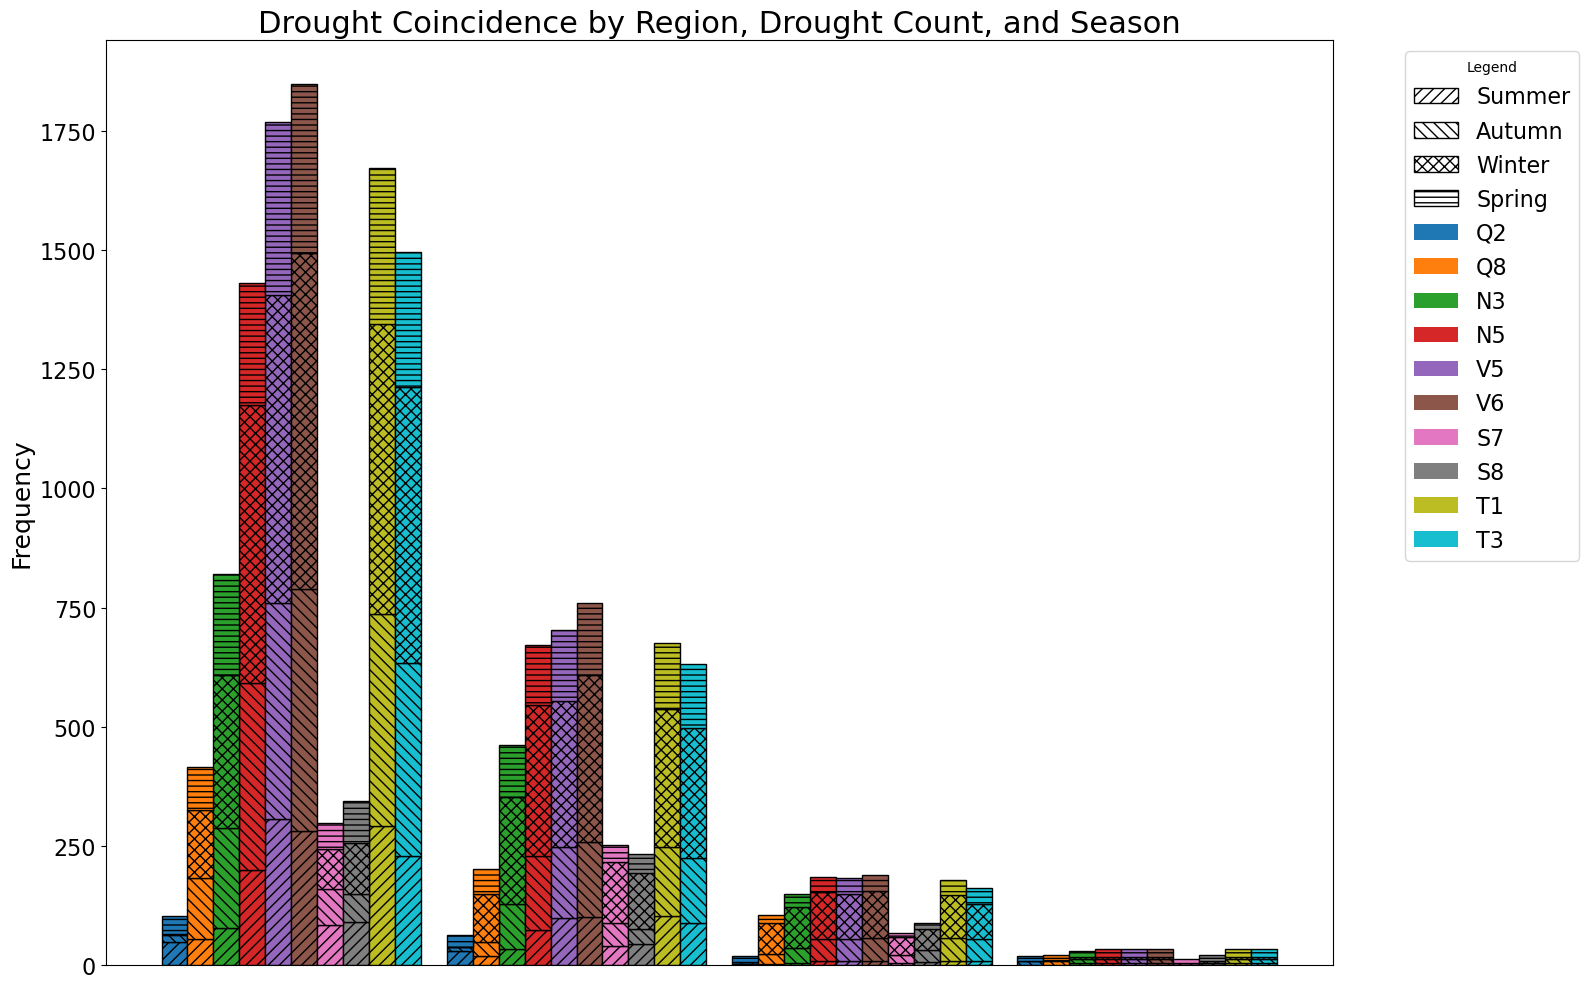

In [76]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(16, 10))

seasons = {
    'summer': [12, 1, 2],
    'autumn': [3, 4, 5],
    'winter': [6, 7, 8],
    'spring': [9, 10, 11]
}

season_hatches = {
    'summer': '///',
    'autumn': '\\\\\\',
    'winter': 'xxx',
    'spring': '---'
}

# Unique colors per region
region_colors = {
    region: plt.cm.tab10(i % 10) for i, region in enumerate(regions)
}

num_droughts_range = list(range(5, 9))
n_droughts = len(num_droughts_range)
n_regions = len(regions)
bar_width = 0.2
group_spacing = 0.2

x_labels = []
x_positions = []
season_data_by_region = {season: [] for season in seasons}
region_ids = []

# Compute data
for i_d, num_droughts in enumerate(num_droughts_range):
    group_start = i_d * (n_regions * bar_width + group_spacing)

    for i_r, region in enumerate(regions):
        x = group_start + i_r * bar_width
        x_positions.append(x)
        x_labels.append(f"{region}\n({num_droughts})")
        region_ids.append(region)

        for season_name, months in seasons.items():
            seasonal_data = coincident_da.where(coincident_da.time.dt.month.isin(months), drop=True)
            times = seasonal_data[seasonal_data == num_droughts].time.data
            value = coincident_drought_ds[region].sel(time=times).data.sum()
            season_data_by_region[season_name].append(value)

# Stack bars with region colors and season hatches
bottom = np.zeros(len(x_positions))
for season_name, values in season_data_by_region.items():
    for idx, (x, height) in enumerate(zip(x_positions, values)):
        region = region_ids[idx]
        ax.bar(
            x,
            height,
            bottom=bottom[idx],
            width=bar_width,
            color=region_colors[region],
            edgecolor='black',
            hatch=season_hatches[season_name]
        )
        bottom[idx] += height

# Formatting
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylabel("Frequency")
ax.set_title("Drought Coincidence by Region, Drought Count, and Season")

# Legend
from matplotlib.patches import Patch
season_legend = [Patch(facecolor='white', hatch=h, edgecolor='black', label=season.capitalize())
                 for season, h in season_hatches.items()]
region_legend = [Patch(facecolor=color, label=region) for region, color in region_colors.items()]
ax.legend(handles=season_legend + region_legend, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

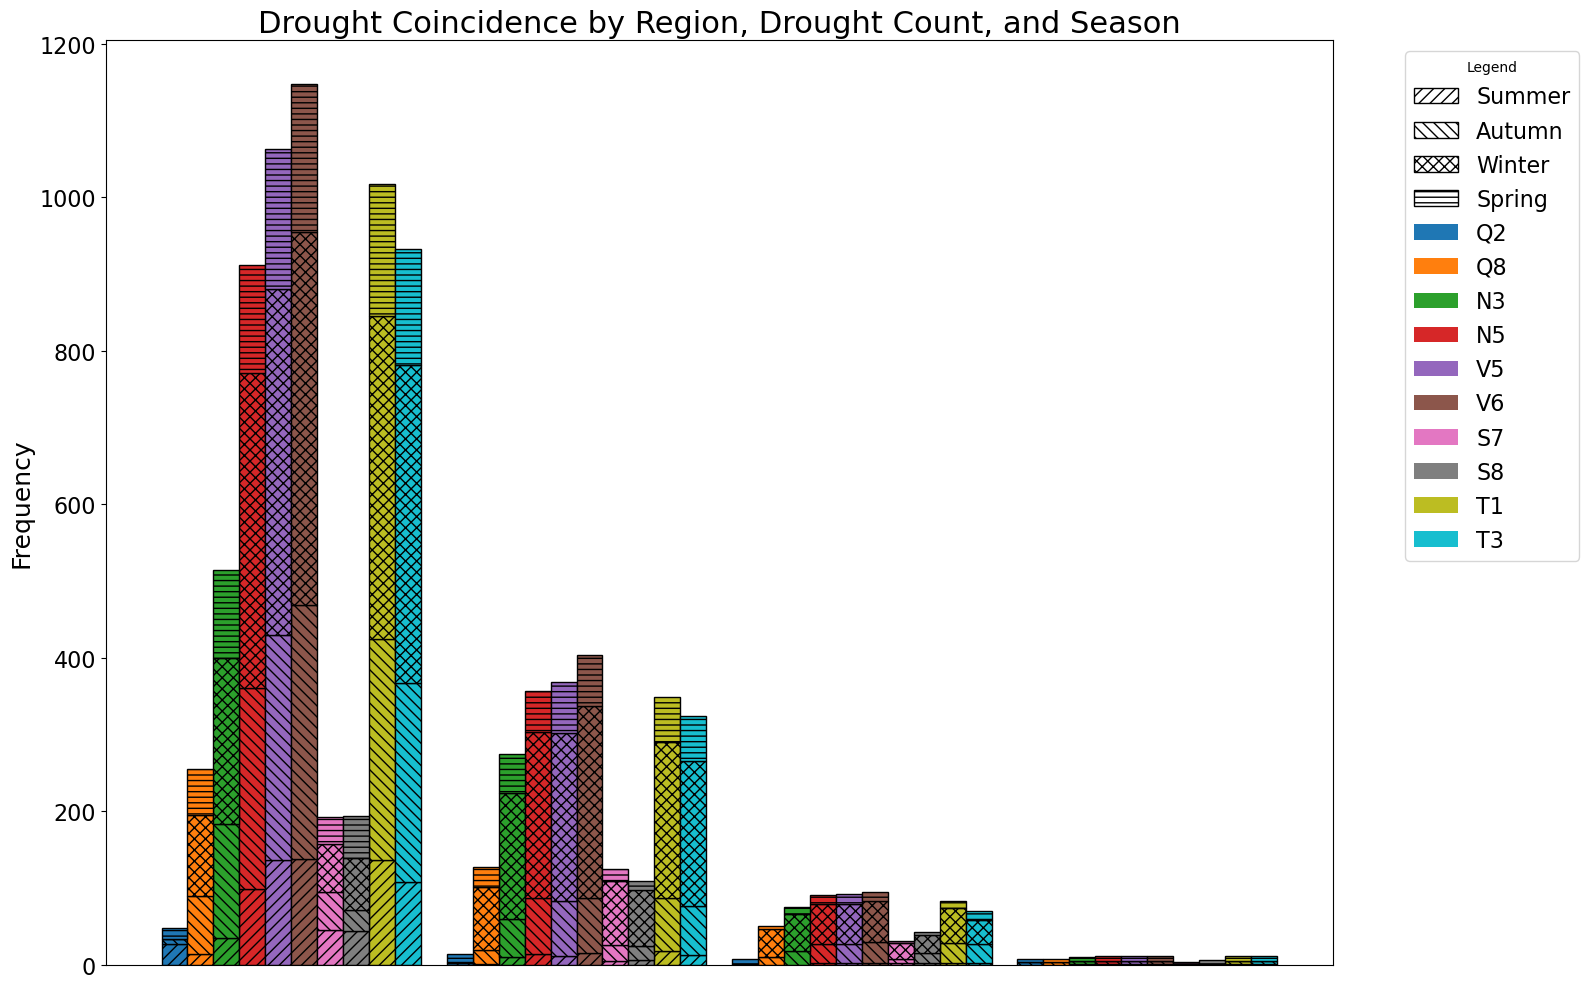

In [77]:
fig, ax = plt.subplots(figsize=(16, 10))

seasons = {
    'summer': [12, 1, 2],
    'autumn': [3, 4, 5],
    'winter': [6, 7, 8],
    'spring': [9, 10, 11]
}

season_hatches = {
    'summer': '///',
    'autumn': '\\\\\\',
    'winter': 'xxx',
    'spring': '---'
}

# Unique colors per region
region_colors = {
    region: plt.cm.tab10(i % 10) for i, region in enumerate(regions)
}

num_droughts_range = list(range(5, 9))
n_droughts = len(num_droughts_range)
n_regions = len(regions)
bar_width = 0.2
group_spacing = 0.2

x_labels = []
x_positions = []
season_data_by_region = {season: [] for season in seasons}
region_ids = []

# Compute data
for i_d, num_droughts in enumerate(num_droughts_range):
    group_start = i_d * (n_regions * bar_width + group_spacing)

    for i_r, region in enumerate(regions):
        x = group_start + i_r * bar_width
        x_positions.append(x)
        x_labels.append(f"{region}\n({num_droughts})")
        region_ids.append(region)

        for season_name, months in seasons.items():
            seasonal_data = coincident_da_hourly.where(coincident_da_hourly.time.dt.month.isin(months), drop=True)
            times = seasonal_data[seasonal_data == num_droughts].time.data
            value = coincident_drought_ds[region].sel(time=times).data.sum()
            season_data_by_region[season_name].append(value)

# Stack bars with region colors and season hatches
bottom = np.zeros(len(x_positions))
for season_name, values in season_data_by_region.items():
    for idx, (x, height) in enumerate(zip(x_positions, values)):
        region = region_ids[idx]
        ax.bar(
            x,
            height,
            bottom=bottom[idx],
            width=bar_width,
            color=region_colors[region],
            edgecolor='black',
            hatch=season_hatches[season_name]
        )
        bottom[idx] += height

# Formatting
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_ylabel("Frequency")
ax.set_title("Drought Coincidence by Region, Drought Count, and Season")

# Legend
from matplotlib.patches import Patch
season_legend = [Patch(facecolor='white', hatch=h, edgecolor='black', label=season.capitalize())
                 for season, h in season_hatches.items()]
region_legend = [Patch(facecolor=color, label=region) for region, color in region_colors.items()]
ax.legend(handles=season_legend + region_legend, title="Legend", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

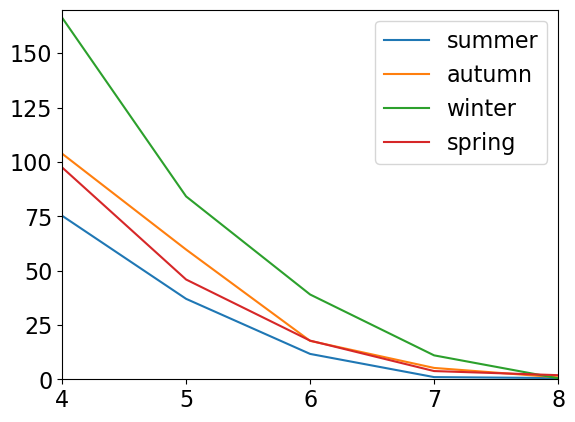

In [24]:
seasons = {
    'summer': [12,1,2],
    'autumn': [3,4,5],
    'winter': [6,7,8],
    'spring': [9,10,11]
}

for season in seasons:
    data = coincident_da.where(coincident_da.time.dt.month.isin(seasons[season]), drop=True).values
    num, freq = np.unique(data.data, return_counts=True)
    num = num[1:]
    freq = freq[1:] / len(np.unique(coincident_da.time.dt.year))
    plt.plot(num, freq, label=season)
    # plt.yscale('log')
    plt.xlim(4,8)
    plt.ylim(0,170)
plt.legend()

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'


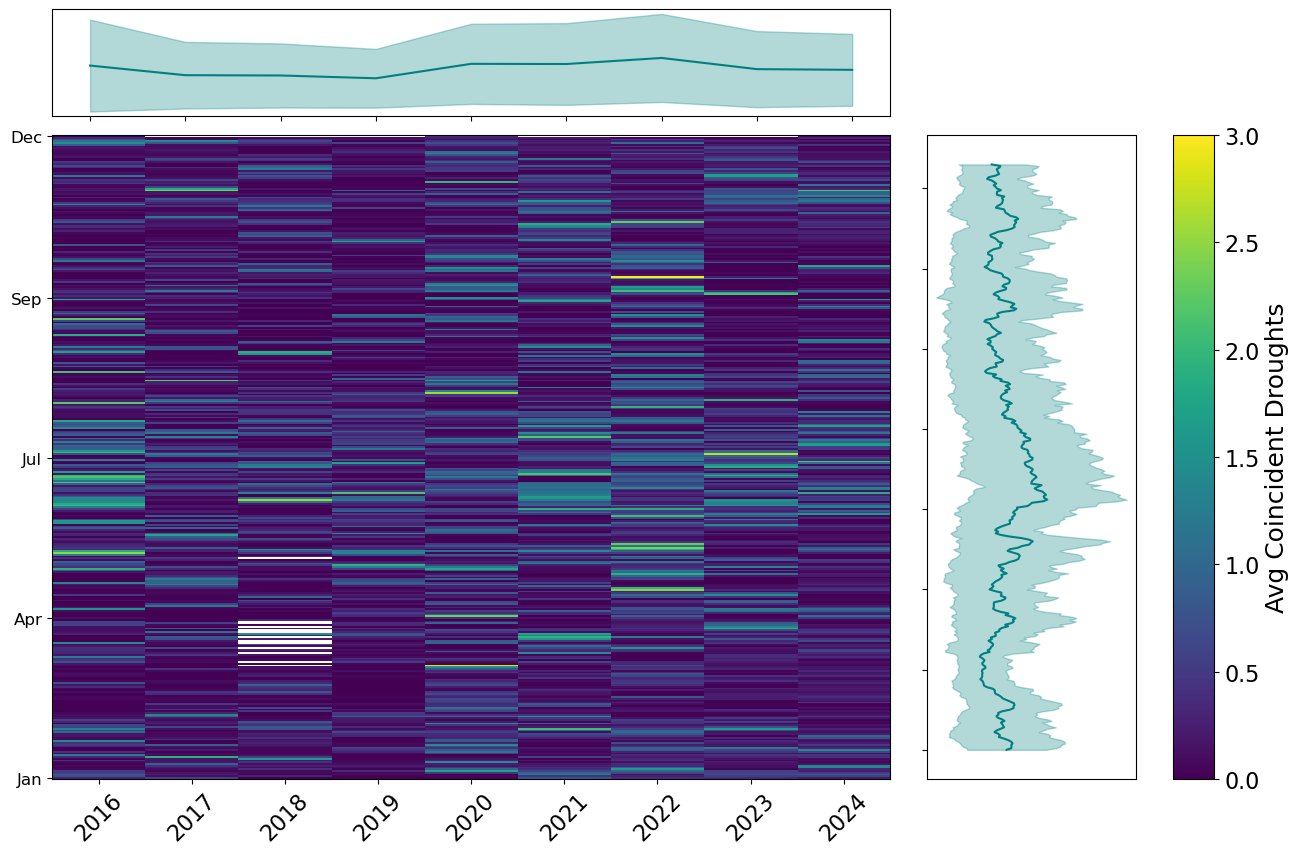

In [25]:
# Prepare data
# Prepare data
coincident_daily = coincident_da.resample(time="1D").mean()
df = solar_plotting.day_year_df(coincident_daily)
# df[df == 0] = np.nan

# Create the figure and gridspec
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(
    2, 3,  # 3 columns: [left (plots), right lineplot, colorbar]
    width_ratios=[4, 1, 0.2],  # Adjust third column for cbar
    height_ratios=[1, 6],
    wspace=0.1,
    hspace=0.05
)

# Create axes
ax_top = fig.add_subplot(gs[0, 0])        # top line plot
ax_heatmap = fig.add_subplot(gs[1, 0])    # main heatmap
ax_right = fig.add_subplot(gs[1, 1])  # right line plot
cbar_ax = fig.add_subplot(gs[1, 2]) 

# Colormap
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Heatmap
im = ax_heatmap.imshow(df, aspect="auto", origin="lower", cmap=cmap, vmin=0, vmax=3, interpolation='none')
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Avg Coincident Droughts', fontsize=18)

# X-axis: years
xticks = np.arange(len(df.columns))
xtick_labels = df.columns.astype(str)
ax_heatmap.set_xticks(xticks)
ax_heatmap.set_xticklabels(xtick_labels, rotation=45)

# Axis ticks - y
yticks = np.linspace(0, len(df.index) - 1, 5, dtype=int)
ytick_labels = [(pd.Timestamp("2024-01-01") + pd.Timedelta(days=int(df.index[j]) - 1)).strftime("%b") for j in yticks]
ax_heatmap.set_yticks(yticks)
ax_heatmap.set_yticklabels(ytick_labels, fontsize=12)

# Top plot (mean and std across days for each time of day)
mean_daily = df.mean(axis=0)
std_daily = df.std(axis=0)
ax_top.plot(mean_daily.values, color='teal')
ax_top.fill_between(
    np.arange(len(mean_daily)),
    mean_daily - std_daily,
    mean_daily + std_daily,
    color='teal',
    alpha=0.3
)
ax_top.tick_params(axis='x', labelbottom=False)
ax_top.set_yticks([])

# Right plot (mean and std across hours for each day of year)
mean_weekly = df.mean(axis=1).rolling(window=7, center=True, min_periods=1).mean()
std_weekly = df.std(axis=1).rolling(window=7, center=True, min_periods=1).mean()
y = np.arange(df.shape[0])
ax_right.plot(mean_weekly.values, y, color="teal")
ax_right.fill_betweenx(
    y,
    mean_weekly - std_weekly,
    mean_weekly + std_weekly,
    color="teal",
    alpha=0.3
)
ax_right.tick_params(axis='y', labelleft=False)
ax_right.set_xticks([])

plt.show()

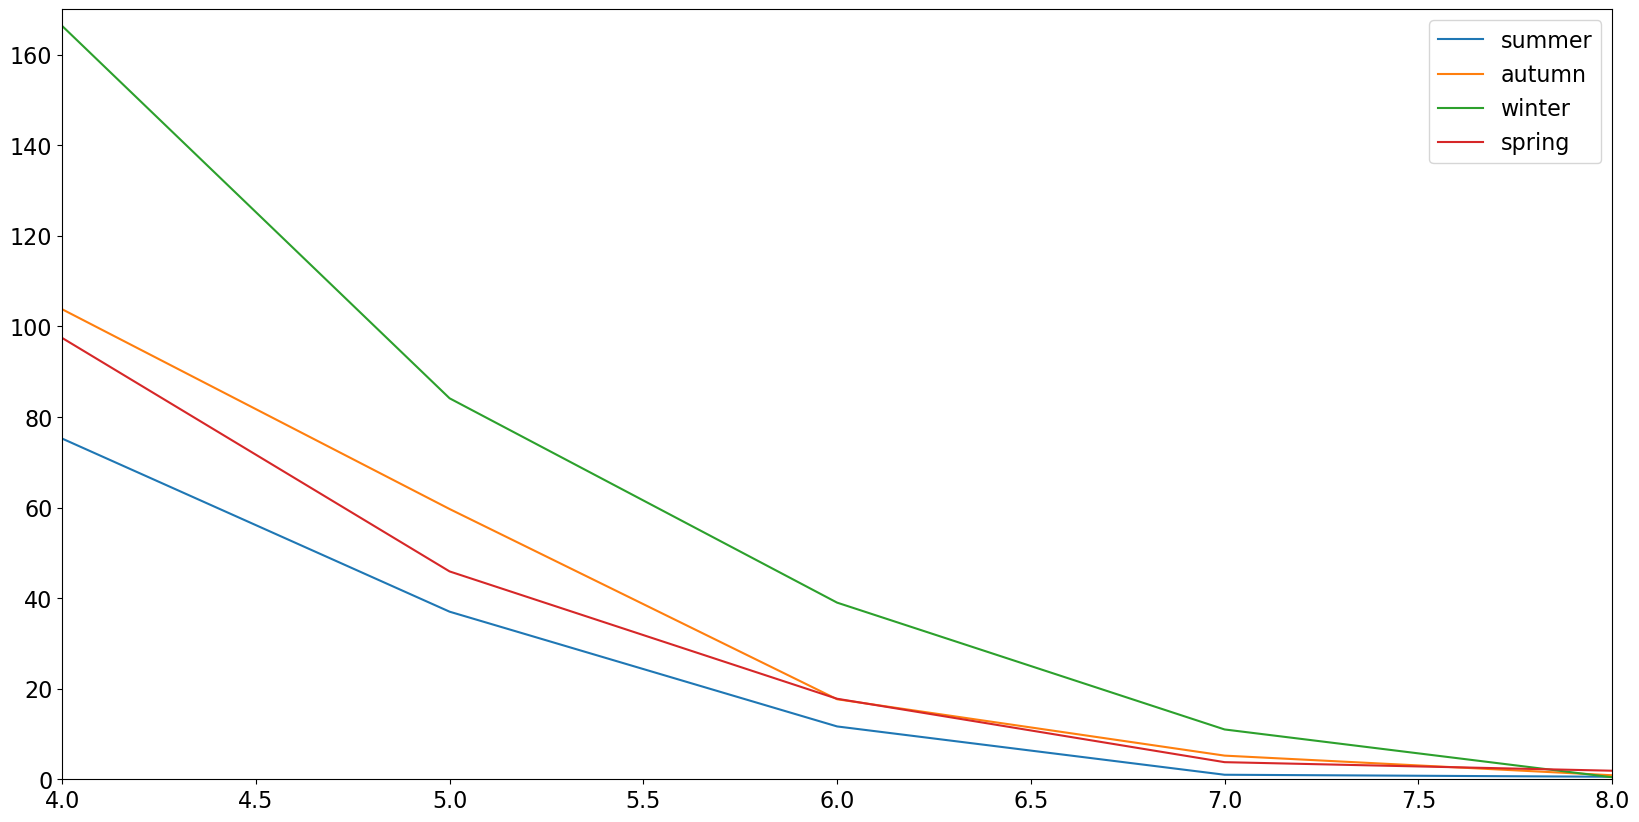

In [26]:
seasons = {
    'summer': [12,1,2],
    'autumn': [3,4,5],
    'winter': [6,7,8],
    'spring': [9,10,11]
}
fig, ax = plt.subplots(figsize=(20,10))
for season in seasons:
    data = coincident_da.where(coincident_da.time.dt.month.isin(seasons[season]), drop=True).values
    num, freq = np.unique(data.data, return_counts=True)
    num = num[1:]
    freq = freq[1:] / len(np.unique(coincident_da.time.dt.year))
    ax.plot(num, freq, label=season)
    # plt.yscale('log')
    ax.set_xlim(4,8)
    ax.set_ylim(0,170)
ax.legend()

# Worst Events

In [27]:
threshold = 0.26
data = ds_aus.total.dropna(dim='time').rolling(time=100).mean()
events = xr.where(data < threshold, data, np.nan).dropna(dim='time')
np.unique(events.time.to_index().date)

array([datetime.date(2016, 6, 18), datetime.date(2016, 6, 19),
       datetime.date(2016, 6, 20), datetime.date(2023, 7, 4),
       datetime.date(2023, 7, 5)], dtype=object)

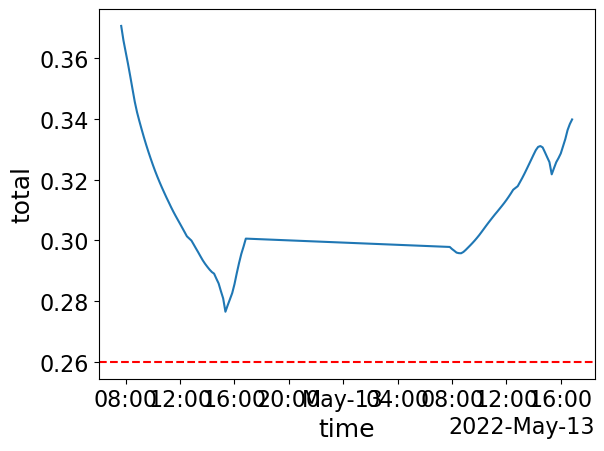

In [28]:
ds_aus.total.dropna(dim='time').rolling(time=100).mean().sel(time=slice('2022-05-12', '2022-05-13')).plot()
plt.axhline(threshold, color='r', linestyle = '--')

# Spectral Analysis

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'flox'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering 

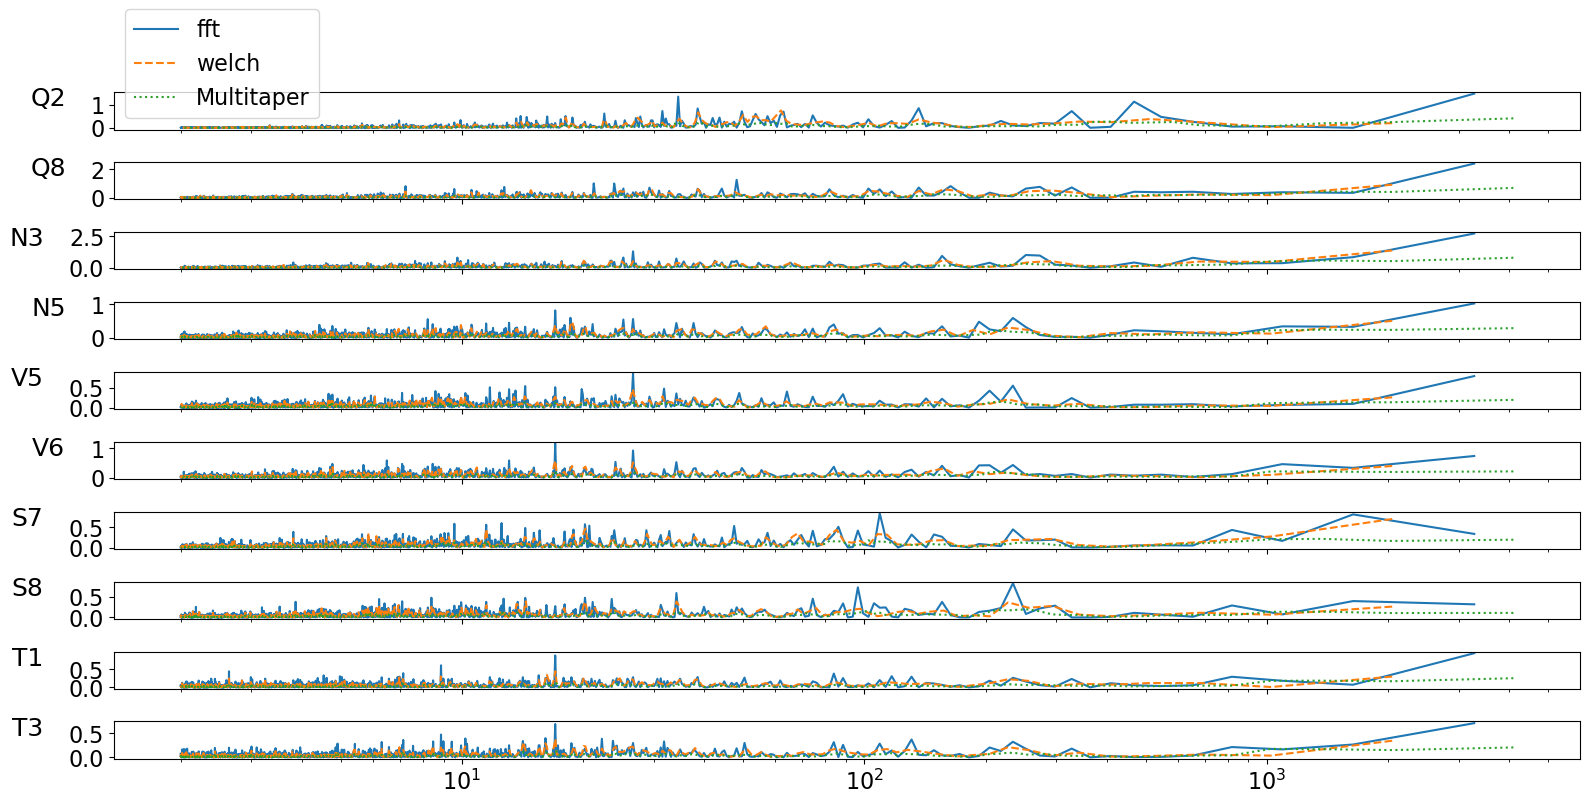

In [29]:
colours = ['red', 'orange', 'blue', 'green', 'purple']
time_res = '1D'
clim = True

fig, ax = plt.subplots(nrows = len(regions), ncols = 1, figsize=(16,8), sharex=True)

for i, reg in enumerate(regions):

    fft_periods, fft_power = solar_plotting.spectral_fft(da=ds_aus[reg], time_res=time_res, clim=clim)
    welch_periods, welch_power = solar_plotting.spectral_welch(da=ds_aus[reg], nperseg=2048, time_res=time_res, clim=clim)
    mt_periods, mt_power = solar_plotting.spectral_multitaper(da=ds_aus[reg], NW=2.5, k=4, time_res=time_res, clim=clim)
    mt_mask = mt_periods >= np.min(fft_periods)
    
    ax[i].semilogx(fft_periods, fft_power, label='fft')
    ax[i].semilogx(welch_periods, welch_power, label='welch', linestyle = '--')
    ax[i].semilogx(mt_periods[mt_mask], mt_power[mt_mask], label='Multitaper', linestyle = ':')
    ax[i].set_ylabel(reg, rotation=0, labelpad=30)
    # ax[i].set_xlim(1,100)
    # ax[i].set_ylim(0,20)
    
    fig.gca().invert_xaxis()
ax[0].legend()
plt.tight_layout()

In [30]:
# Wavelet

variables = ['Q', 'N', 'V', 'S', 'T']

for var in variables:
    # daily = ds_aus[var].resample(time="1D").mean()
    clean = ds_aus[var].dropna(dim="time")
    data = clean - clean.mean(dim="time")
    signal = data.values
    
    scales = np.arange(1, 100)
    coefficients, freqs = pywt.cwt(signal, scales=scales, wavelet='morl', sampling_period=1)
    
    # Compute power and apply log scale (add small constant to avoid log(0))
    power = np.abs(coefficients) ** 2
    log_power = np.log2(power + 1e-8)
    
    plt.figure(figsize=(14, 6))
    im = plt.imshow(power,
                    extent=[0, len(signal), scales[-1], scales[0]], vmax = 3,
                    aspect='auto', cmap='RdYlBu_r')
    
    plt.gca().invert_yaxis()
    cbar = plt.colorbar(im)
    cbar.set_label("Power")
    
    plt.xlabel("Time (samples since start)")
    plt.ylabel("Period (days)")
    plt.title("Wavelet Power Spectrum")
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

KeyError: "No variable named 'Q'. Variables on the dataset include ['Q2', 'Q8', 'N3', 'N5', 'V5', ..., 'S8', 'T1', 'T3', 'time', 'total']"